# Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import regex as re

import inflection

from matplotlib              import pyplot as plt
from plotly                  import express as px
from IPython.core.display    import HTML

from sklearn                 import cluster as c
from yellowbrick.cluster     import KElbowVisualizer, SilhouetteVisualizer
from sklearn                 import metrics as m
from sklearn                 import manifold as mn
from pandas_profiling        import ProfileReport
from sklearn.preprocessing   import MinMaxScaler, StandardScaler
from sklearn.ensemble        import RandomForestRegressor 

# Helper funtions

In [2]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    sns.set()
jupyter_settings()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


C:\Users\Lavin\anaconda3\envs\insiders_clustering\lib\site-packages\IPython\core\magics\pylab.py:162: UserWarning: pylab import has clobbered these variables: ['re']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


# load data

In [3]:
df_raw = pd.read_csv('../data/raw/Ecommerce.csv',encoding= 'unicode_escape')

In [4]:
df_raw.head()

InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

  InvoiceDate  UnitPrice  CustomerID         Country  Unnamed: 8  
0   29-Nov-16       2.55     17850.0  United Kingdom         NaN  
1   29-Nov-16       3.39     17850.0  United Kingdom         NaN  
2   29-Nov-16       2.75     17850.0  United Kingdom         NaN  
3   29-Nov-16       3.39     17850.0  United Kingdom         NaN  
4   29-Nov-16       3.39     17850.0  United Kingdom         NaN

In [5]:
df1 = df_raw.copy()

**data dimensions**

In [6]:
df1.shape

(541909, 9)

**Rename columns**

In [7]:
old_cols = df1.columns
snakecase = lambda x: inflection.underscore(x)
new_cols = list(map(snakecase,old_cols))
df1.columns = new_cols

In [8]:
df1.columns

Index(['invoice_no', 'stock_code', 'description', 'quantity', 'invoice_date',
       'unit_price', 'customer_id', 'country', 'unnamed: 8'],
      dtype='object')

**delete column**

In [9]:
df1.drop(columns='unnamed: 8',inplace=True)

In [10]:
df1.head()

invoice_no stock_code                          description  quantity  \
0     536365     85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1     536365      71053                  WHITE METAL LANTERN         6   
2     536365     84406B       CREAM CUPID HEARTS COAT HANGER         8   
3     536365     84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4     536365     84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

  invoice_date  unit_price  customer_id         country  
0    29-Nov-16        2.55      17850.0  United Kingdom  
1    29-Nov-16        3.39      17850.0  United Kingdom  
2    29-Nov-16        2.75      17850.0  United Kingdom  
3    29-Nov-16        3.39      17850.0  United Kingdom  
4    29-Nov-16        3.39      17850.0  United Kingdom

# Data types

In [11]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

# Checking NA

In [12]:
df1.isnull().sum()/len(df_raw)*100

invoice_no       0.000000
stock_code       0.000000
description      0.268311
quantity         0.000000
invoice_date     0.000000
unit_price       0.000000
customer_id     24.926694
country          0.000000
dtype: float64

## replace NA

In [13]:
df_missing = df1.loc[df1['customer_id'].isna(),:]
df_missing.head()

invoice_no stock_code                      description  quantity  \
622      536414      22139                              NaN        56   
1443     536544      21773  DECORATIVE ROSE BATHROOM BOTTLE         1   
1444     536544      21774  DECORATIVE CATS BATHROOM BOTTLE         2   
1445     536544      21786               POLKADOT RAIN HAT          4   
1446     536544      21787            RAIN PONCHO RETROSPOT         2   

     invoice_date  unit_price  customer_id         country  
622     29-Nov-16        0.00          NaN  United Kingdom  
1443    29-Nov-16        2.51          NaN  United Kingdom  
1444    29-Nov-16        2.51          NaN  United Kingdom  
1445    29-Nov-16        0.85          NaN  United Kingdom  
1446    29-Nov-16        1.66          NaN  United Kingdom

In [14]:
df_not_missing = df1.loc[~df1['customer_id'].isna(),:]
df_not_missing

invoice_no stock_code                          description  quantity  \
0          536365     85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1          536365      71053                  WHITE METAL LANTERN         6   
2          536365     84406B       CREAM CUPID HEARTS COAT HANGER         8   
3          536365     84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4          536365     84029E       RED WOOLLY HOTTIE WHITE HEART.         6   
...           ...        ...                                  ...       ...   
541904     581587      22613          PACK OF 20 SPACEBOY NAPKINS        12   
541905     581587      22899         CHILDREN'S APRON DOLLY GIRL          6   
541906     581587      23254        CHILDRENS CUTLERY DOLLY GIRL          4   
541907     581587      23255      CHILDRENS CUTLERY CIRCUS PARADE         4   
541908     581587      22138        BAKING SET 9 PIECE RETROSPOT          3   

       invoice_date  unit_price  customer_id         country  
0         29-Nov-16        2.55      17850.0  United Kingdom  
1         29-Nov-16        3.39      17850.0  United Kingdom  
2         29-Nov-16        2.75      17850.0  United Kingdom  
3         29-Nov-16        3.39      17850.0  United Kingdom  
4         29-Nov-16        3.39      17850.0  United Kingdom  
...             ...         ...          ...             ...  
541904     7-Dec-17        0.85      12680.0          France  
541905     7-Dec-17        2.10      12680.0          France  
541906     7-Dec-17        4.15      12680.0          France  
541907     7-Dec-17        4.15      12680.0          France  
541908     7-Dec-17        4.95      12680.0          France  

[406829 rows x 8 columns]

In [15]:
# create reference
df_backup = pd.DataFrame(df_missing['invoice_no'].drop_duplicates())
df_backup['customer_id'] = np.arange(19000,19000+len(df_backup),1)

#merge original with reference
df1 = pd.merge(df1,df_backup,on='invoice_no',how='left')

#coalesce
df1['customer_id'] = df1['customer_id_x'].combine_first(df1['customer_id_y'])

df1 = df1.drop(columns=['customer_id_x','customer_id_y'])

In [16]:
df1.isnull().sum()

invoice_no         0
stock_code         0
description     1454
quantity           0
invoice_date       0
unit_price         0
country            0
customer_id        0
dtype: int64

In [17]:
df_backup.head()

invoice_no  customer_id
622      536414        19000
1443     536544        19001
1970     536545        19002
1971     536546        19003
1972     536547        19004

In [18]:
#df1 = df1.dropna(subset=['description','customer_id'])

In [19]:
1- df1.shape[0]/df_raw.shape[0]

0.0

In [20]:
df1.isnull().sum()

invoice_no         0
stock_code         0
description     1454
quantity           0
invoice_date       0
unit_price         0
country            0
customer_id        0
dtype: int64

# Chaging types

In [21]:
df1['invoice_date'] = pd.to_datetime(df1['invoice_date'],format='%d-%b-%y')

In [22]:
df1['invoice_date']

0        2016-11-29
1        2016-11-29
2        2016-11-29
3        2016-11-29
4        2016-11-29
            ...    
541904   2017-12-07
541905   2017-12-07
541906   2017-12-07
541907   2017-12-07
541908   2017-12-07
Name: invoice_date, Length: 541909, dtype: datetime64[ns]

In [23]:
#df1['invoice_no'].astype(int)

In [24]:
df1.dtypes

invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
country                 object
customer_id            float64
dtype: object

'Invoice_no' possui letras em algumas linhas, necessita de limpeza mais detalhada

# Data description

In [25]:
df1.head()

invoice_no stock_code                          description  quantity  \
0     536365     85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1     536365      71053                  WHITE METAL LANTERN         6   
2     536365     84406B       CREAM CUPID HEARTS COAT HANGER         8   
3     536365     84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4     536365     84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

  invoice_date  unit_price         country  customer_id  
0   2016-11-29        2.55  United Kingdom      17850.0  
1   2016-11-29        3.39  United Kingdom      17850.0  
2   2016-11-29        2.75  United Kingdom      17850.0  
3   2016-11-29        3.39  United Kingdom      17850.0  
4   2016-11-29        3.39  United Kingdom      17850.0

'invoice_no', : categorical atributtes

'stock_code': categorical atributtes

'description': categorical atributtes

'quantity': numerical atributtes

'invoice_date': numerical atributtes

'unit_price': numerical atributtes

'customer_id': categorical atributtes

'country': categorical atributtes

In [26]:
num_atributtes = df1[['quantity','unit_price','invoice_date']]
cat_atributtes = df1[['customer_id','description','country','invoice_no','stock_code']]

## numerical statistcs

In [27]:
num_statistcs = num_atributtes.agg(['min','max','mean','median','std','skew','kurtosis']).T
num_statistcs['range'] = num_statistcs['max'] - num_statistcs['min']
num_statistcs= num_statistcs[['min','max','range','mean','median','std','skew','kurtosis']]
num_statistcs

min                  max              range  \
quantity                 -80995.0              80995.0           161990.0   
unit_price              -11062.06              38970.0           50032.06   
invoice_date  2016-11-29 00:00:00  2017-12-07 00:00:00  373 days 00:00:00   

                                       mean               median  \
quantity                            9.55225                  3.0   
unit_price                         4.611114                 2.08   
invoice_date  2017-07-02 00:00:13.073782016  2017-07-17 00:00:00   

                                      std        skew       kurtosis  
quantity                       218.081158   -0.264076  119769.160031  
unit_price                      96.759853  186.506972   59005.719097  
invoice_date  115 days 21:02:59.177457004         NaN            NaN

1. - Quantity negativa (pode ser devolução)
2. - Preço unitário igual a zero (promoção?)

## Categorical statistcs

In [28]:
cat_atributtes.apply(lambda x: x.unique().shape[0])

customer_id     8082
description     4224
country           38
invoice_no     25900
stock_code      4070
dtype: int64

In [29]:
# Invoice no
#cat_atributtes.loc[cat_atributtes['invoice_no'].apply(lambda x: bool(re.search('[^0-9]+',x))),:].drop_duplicates()
df_letter_invoice = df1.loc[df1['invoice_no'].apply(lambda x: bool(re.search('[^0-9]+',x))),:]

df_letter_invoice

invoice_no stock_code                       description  quantity  \
141       C536379          D                          Discount        -1   
154       C536383     35004C   SET OF 3 COLOURED  FLYING DUCKS        -1   
235       C536391      22556    PLASTERS IN TIN CIRCUS PARADE        -12   
236       C536391      21984  PACK OF 12 PINK PAISLEY TISSUES        -24   
237       C536391      21983  PACK OF 12 BLUE PAISLEY TISSUES        -24   
...           ...        ...                               ...       ...   
540449    C581490      23144   ZINC T-LIGHT HOLDER STARS SMALL       -11   
541541    C581499          M                            Manual        -1   
541715    C581568      21258        VICTORIAN SEWING BOX LARGE        -5   
541716    C581569      84978  HANGING HEART JAR T-LIGHT HOLDER        -1   
541717    C581569      20979     36 PENCILS TUBE RED RETROSPOT        -5   

       invoice_date  unit_price         country  customer_id  
141      2016-11-29       27.50  United Kingdom      14527.0  
154      2016-11-29        4.65  United Kingdom      15311.0  
235      2016-11-29        1.65  United Kingdom      17548.0  
236      2016-11-29        0.29  United Kingdom      17548.0  
237      2016-11-29        0.29  United Kingdom      17548.0  
...             ...         ...             ...          ...  
540449   2017-12-07        0.83  United Kingdom      14397.0  
541541   2017-12-07      224.69  United Kingdom      15498.0  
541715   2017-12-07       10.95  United Kingdom      15311.0  
541716   2017-12-07        1.25  United Kingdom      17315.0  
541717   2017-12-07        1.25  United Kingdom      17315.0  

[9291 rows x 8 columns]

In [30]:
len(df_letter_invoice)

9291

Todas os pedidos que possuem letra no 'invoice_no', também possuem valores positivos de quantidade

In [31]:
len(df1[df1['quantity']<0])

10624

A quantidade de pedidos que tem 'quantity' menor ou igual a zero é igual a quantidade de pedidos que possuem letra no código 'invoice_no' 

Logo se supõem que pedidos com letras no 'inovice_no' são devoluções

In [32]:
# stock code
cat_atributtes.loc[cat_atributtes['stock_code'].apply(lambda x: bool(re.search('^[a-zA-Z]+$',x))),'stock_code'].unique()

array(['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY',
       'DCGSSGIRL', 'PADS', 'B', 'CRUK'], dtype=object)

In [33]:
# description
# remoção da descrição

In [34]:
cat_atributtes['country'].unique()

array(['United Kingdom', 'France', 'Australia', 'Netherlands', 'Germany',
       'Norway', 'EIRE', 'Switzerland', 'Spain', 'Poland', 'Portugal',
       'Italy', 'Belgium', 'Lithuania', 'Japan', 'Iceland',
       'Channel Islands', 'Denmark', 'Cyprus', 'Sweden', 'Austria',
       'Israel', 'Finland', 'Bahrain', 'Greece', 'Hong Kong', 'Singapore',
       'Lebanon', 'United Arab Emirates', 'Saudi Arabia',
       'Czech Republic', 'Canada', 'Unspecified', 'Brazil', 'USA',
       'European Community', 'Malta', 'RSA'], dtype=object)

In [35]:
cat_atributtes['country'].value_counts(normalize=True)

United Kingdom          0.914320
Germany                 0.017521
France                  0.015790
EIRE                    0.015124
Spain                   0.004674
Netherlands             0.004375
Belgium                 0.003818
Switzerland             0.003694
Portugal                0.002803
Australia               0.002323
Norway                  0.002004
Italy                   0.001482
Channel Islands         0.001399
Finland                 0.001283
Cyprus                  0.001148
Sweden                  0.000853
Unspecified             0.000823
Austria                 0.000740
Denmark                 0.000718
Japan                   0.000661
Poland                  0.000629
Israel                  0.000548
USA                     0.000537
Hong Kong               0.000531
Singapore               0.000423
Iceland                 0.000336
Canada                  0.000279
Greece                  0.000269
Malta                   0.000234
United Arab Emirates    0.000125
European C

Remover 'European Community' e 'Unspecified'

# Filter

In [36]:
df2 = df1.copy()

In [37]:
# unit price > 0.0
df2 = df2.loc[df2['unit_price'] > 0.040,:]

#stock code != ['POST','D','M','DOT','CRUK','C2']
df2 = df2[~df2['stock_code'].isin(['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY','DCGSSGIRL', 'PADS', 'B', 'CRUK','C2'])]

# description
df2.drop(columns='description',inplace=True)

# country
df2 = df2[~df2['country'].isin(['European Community','Unspecified'])]


df2 = df2[~df2['customer_id'].isin([16446])]


# description
## quantity - Negative numbers means product returns
df_returns = df2.loc[df2['quantity']<0,:]
df_purchase = df2.loc[df2['quantity']>0,:]

# Features enginering

In [38]:
df3 = df2.copy()

In [39]:
df3.head()

invoice_no stock_code  quantity invoice_date  unit_price         country  \
0     536365     85123A         6   2016-11-29        2.55  United Kingdom   
1     536365      71053         6   2016-11-29        3.39  United Kingdom   
2     536365     84406B         8   2016-11-29        2.75  United Kingdom   
3     536365     84029G         6   2016-11-29        3.39  United Kingdom   
4     536365     84029E         6   2016-11-29        3.39  United Kingdom   

   customer_id  
0      17850.0  
1      17850.0  
2      17850.0  
3      17850.0  
4      17850.0

## Feature creation

In [40]:
df_ref = pd.DataFrame(df3['customer_id'])

In [41]:
df_ref =  df_ref.drop_duplicates(ignore_index=True)

### Receita bruta

**Gross Revenue**

In [42]:
df_purchase.loc[:,'gross_revenue'] = df_purchase.loc[:,'quantity'] * df_purchase.loc[:,'unit_price']
df_monetary = df_purchase[['customer_id','gross_revenue']].groupby('customer_id').sum().reset_index()
df_ref = pd.merge(df_ref,df_monetary,on='customer_id',how='left')

C:\Users\Lavin\anaconda3\envs\insiders_clustering\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


### Rencencia - dias da ultima compra

In [43]:
df_recency = df_purchase[['customer_id','invoice_date']].groupby('customer_id').max().reset_index()
df_recency['recency_days'] = (df2['invoice_date'].max()- df_recency['invoice_date']).dt.days
df_recency = df_recency.drop(columns = 'invoice_date')
df_ref = pd.merge(df_ref,df_recency,on='customer_id',how='left')

### Quantidade de compras

In [44]:
df_purc_quant = (df_purchase[['customer_id','invoice_no']].drop_duplicates()
                                                         .groupby('customer_id')
                                                         .count()
                                                         .reset_index()
                                                         .rename(columns = {'invoice_no':'qtde_invoice'}))
df_ref = pd.merge(df_ref,df_purc_quant,on='customer_id',how='left')

### Quantidade de itens comprados

In [45]:
df_item_quant = (df_purchase[['customer_id','quantity']].groupby('customer_id')
                                                       .sum()
                                                       .reset_index()
                                                       .rename(columns = {'quantity':'qtde_items'}))
df_ref = pd.merge(df_ref,df_item_quant,on='customer_id',how='left')

### Quantidade de produtos comprados

In [46]:
df_prod_quant = (df_purchase[['customer_id','stock_code']].groupby('customer_id')
                                                       .count()
                                                       .reset_index()
                                                       .rename(columns = {'stock_code':'qtde_products'}))
df_ref = pd.merge(df_ref,df_prod_quant,on='customer_id',how='left')

### Quantidade  de produtos comprados por cesta (basket size)

In [47]:
df_aux = (df_purchase.loc[:,['customer_id','invoice_no','quantity']].groupby('customer_id')
                                                          .agg(n_purchase = ('invoice_no','nunique'),
                                                               n_products = ('quantity','sum'))
                                                          .reset_index())

df_aux['avg_basket_size'] = df_aux['n_products']/df_aux['n_purchase']

#merge
df_ref = pd.merge(df_ref,df_aux[['avg_basket_size','customer_id']],on='customer_id',how='left')

### Quantidade  de produtos unicos comprados por compra (basket size)

In [48]:
df_aux = (df_purchase.loc[:,['customer_id','invoice_no','stock_code']].groupby('customer_id')
                                                          .agg(n_purchase = ('invoice_no','nunique'),
                                                               n_products = ('stock_code','count'))
                                                          .reset_index())

df_aux['avg_unique_basket_size'] = df_aux['n_products']/df_aux['n_purchase']

#merge
df_ref = pd.merge(df_ref,df_aux[['avg_unique_basket_size','customer_id']],on='customer_id',how='left')

### Frequência

**Frequência**

In [49]:
df_aux = (df3[['customer_id','invoice_no','invoice_date']].drop_duplicates()
                                                          .groupby('customer_id')
                                                          .agg(max_ = ('invoice_date','max'),
                                                               min_ = ('invoice_date','min'),
                                                               days_ = ('invoice_date',lambda x:(x.max()-x.min()).days+1),
                                                               buy_  = ('invoice_date','count'))
                                                          .reset_index())
                                                          

df_aux['freq'] = df_aux.apply(lambda x: x['buy_']/x['days_'] if x['days_'] !=0 else 0,axis=1)
df_ref = pd.merge(df_ref,df_aux[['customer_id','freq']],on='customer_id',how='left')

In [50]:
df_ref.isnull().sum()

customer_id                0
gross_revenue             91
recency_days              91
qtde_invoice              91
qtde_items                91
qtde_products             91
avg_basket_size           91
avg_unique_basket_size    91
freq                       0
dtype: int64

### Valor médio do ticket

**Average ticket**

In [51]:
df_avg_ticket = df_purchase[['customer_id','gross_revenue']].groupby('customer_id').mean().reset_index().rename(columns={'gross_revenue':'avg_ticket'})
df_ref = pd.merge(df_ref,df_avg_ticket,on='customer_id',how='left')

### Média de recência em dias

In [52]:
df_aux = df3.loc[:,['customer_id','invoice_date']].drop_duplicates().sort_values(['customer_id','invoice_date'],ascending=['False','False'])
df_aux['next_customer_id'] = df_aux['customer_id'].shift()
df_aux['prev_invoice_date'] = df_aux['invoice_date'].shift()
df_aux['avg_rec_days'] = df_aux.apply(lambda x: (x['invoice_date'] - x['prev_invoice_date']).days if (x['next_customer_id'] == x['customer_id']) else np.nan, axis=1)
df_aux = df_aux.drop(columns=['invoice_date','next_customer_id','prev_invoice_date']).dropna()
df_avf_rec = df_aux.groupby('customer_id').mean().reset_index()
df_avf_rec.head()

# merge
df_ref = pd.merge(df_ref,df_avf_rec, on = 'customer_id',how='left')
df_ref.head()

customer_id  gross_revenue  recency_days  qtde_invoice  qtde_items  \
0      17850.0        5391.21         372.0          34.0      1733.0   
1      13047.0        3232.59          56.0           9.0      1390.0   
2      12583.0        6705.38           2.0          15.0      5028.0   
3      13748.0         948.25          95.0           5.0       439.0   
4      15100.0         876.00         333.0           3.0        80.0   

   qtde_products  avg_basket_size  avg_unique_basket_size      freq  \
0          297.0        50.970588                8.735294  0.486111   
1          171.0       154.444444               19.000000  0.048780   
2          232.0       335.200000               15.466667  0.045699   
3           28.0        87.800000                5.600000  0.017921   
4            3.0        26.666667                1.000000  0.136364   

   avg_ticket  avg_rec_days  
0   18.152222     35.500000  
1   18.904035     27.250000  
2   28.902500     23.187500  
3   33.866071     92.666667  
4  292.000000      8.600000

### Devoluções

**Returns**

In [53]:
df_avg_returns = df_returns[['customer_id','quantity']].drop_duplicates().groupby('customer_id').sum().abs().reset_index().rename(columns={'quantity':'qtde_returns'})
df_ref = pd.merge(df_ref,df_avg_returns,on='customer_id',how='left')
df_ref.loc[df_ref['qtde_returns'].isna(),'qtde_returns'] = 0

In [54]:
df_ref.isnull().sum()

customer_id                  0
gross_revenue               91
recency_days                91
qtde_invoice                91
qtde_items                  91
qtde_products               91
avg_basket_size             91
avg_unique_basket_size      91
freq                         0
avg_ticket                  91
avg_rec_days              2816
qtde_returns                 0
dtype: int64

In [55]:
df_ref = df_ref.dropna()

In [56]:
df_ref.head()

customer_id  gross_revenue  recency_days  qtde_invoice  qtde_items  \
0      17850.0        5391.21         372.0          34.0      1733.0   
1      13047.0        3232.59          56.0           9.0      1390.0   
2      12583.0        6705.38           2.0          15.0      5028.0   
3      13748.0         948.25          95.0           5.0       439.0   
4      15100.0         876.00         333.0           3.0        80.0   

   qtde_products  avg_basket_size  avg_unique_basket_size      freq  \
0          297.0        50.970588                8.735294  0.486111   
1          171.0       154.444444               19.000000  0.048780   
2          232.0       335.200000               15.466667  0.045699   
3           28.0        87.800000                5.600000  0.017921   
4            3.0        26.666667                1.000000  0.136364   

   avg_ticket  avg_rec_days  qtde_returns  
0   18.152222     35.500000          21.0  
1   18.904035     27.250000           6.0  
2   28.902500     23.187500          50.0  
3   33.866071     92.666667           0.0  
4  292.000000      8.600000          22.0

In [57]:
df4 = df_ref.copy()

# EDA

In [58]:
df5 = df4.copy()

In [59]:
df5.head()

customer_id  gross_revenue  recency_days  qtde_invoice  qtde_items  \
0      17850.0        5391.21         372.0          34.0      1733.0   
1      13047.0        3232.59          56.0           9.0      1390.0   
2      12583.0        6705.38           2.0          15.0      5028.0   
3      13748.0         948.25          95.0           5.0       439.0   
4      15100.0         876.00         333.0           3.0        80.0   

   qtde_products  avg_basket_size  avg_unique_basket_size      freq  \
0          297.0        50.970588                8.735294  0.486111   
1          171.0       154.444444               19.000000  0.048780   
2          232.0       335.200000               15.466667  0.045699   
3           28.0        87.800000                5.600000  0.017921   
4            3.0        26.666667                1.000000  0.136364   

   avg_ticket  avg_rec_days  qtde_returns  
0   18.152222     35.500000          21.0  
1   18.904035     27.250000           6.0  
2   28.902500     23.187500          50.0  
3   33.866071     92.666667           0.0  
4  292.000000      8.600000          22.0

## Univariate analysis

Clusters coeses - separados
métricas de variabilidade - min,max,range (dispersão)
                          - média e mediana
                          - desvio padrão e variância
                          - coeficiente de variação (desvio padrão / média)

In [60]:
# profile = ProfileReport(df5)
# profile.to_file('output_v2.html')

**gross_revenue**
    
    - Possivel outiler no valor: 279138.02 
    - variabilidade

**recency_days**

    - variabilidade

**qtde_invoice:**

    - variabilidade

**qtde_items**

    - possivel outlier no valor: 196844
    - variabilidade

**qtde_products:**

    - Possivel outlier no valor: 7837 
    - variablidade

**avg_basket_size:**

    - Possivel outlier no valor: 40498.5  
    - variablidade

**avg_unique_basket_size:**

    - baixa variabilidade

**freq:**

    - variablidade

**avg_ticket:**

    - Possivel outiler no valor: 56157.5 
    - alta variabilidade

**avg_rec_days:**

    - baixa variabilidade

**qtde_returns:**

    - Possivel outlier nos valores: 80995,9014 
    - Alta variabilidade


In [61]:
df5[df5['gross_revenue']==279138.02 ]

customer_id  gross_revenue  recency_days  qtde_invoice  qtde_items  \
1017      14646.0      279138.02           1.0          72.0    196844.0   

      qtde_products  avg_basket_size  avg_unique_basket_size      freq  \
1017         2060.0      2733.944444               28.611111  0.206215   

      avg_ticket  avg_rec_days  qtde_returns  
1017  135.503893      7.844444         144.0

In [62]:
df5[df5['qtde_items']==196844 ]

customer_id  gross_revenue  recency_days  qtde_invoice  qtde_items  \
1017      14646.0      279138.02           1.0          72.0    196844.0   

      qtde_products  avg_basket_size  avg_unique_basket_size      freq  \
1017         2060.0      2733.944444               28.611111  0.206215   

      avg_ticket  avg_rec_days  qtde_returns  
1017  135.503893      7.844444         144.0

In [63]:
df5[df5['qtde_products']==7837]

customer_id  gross_revenue  recency_days  qtde_invoice  qtde_items  \
68      17841.0       40959.72           1.0         124.0     22853.0   

    qtde_products  avg_basket_size  avg_unique_basket_size      freq  \
68         7837.0       184.298387               63.201613  0.453083   

    avg_ticket  avg_rec_days  qtde_returns  
68    5.226454      3.321429          38.0

In [64]:
df5[df5['avg_basket_size']==40498.5]

Empty DataFrame
Columns: [customer_id, gross_revenue, recency_days, qtde_invoice, qtde_items, qtde_products, avg_basket_size, avg_unique_basket_size, freq, avg_ticket, avg_rec_days, qtde_returns]
Index: []

In [65]:
df5[df5['qtde_returns']==9014]
#df3[df3['customer_id']==15749 ]

customer_id  gross_revenue  recency_days  qtde_invoice  qtde_items  \
1262      15749.0        44534.3         235.0           3.0     18028.0   

      qtde_products  avg_basket_size  avg_unique_basket_size      freq  \
1262           10.0      6009.333333                3.333333  0.040816   

      avg_ticket  avg_rec_days  qtde_returns  
1262     4453.43          97.0        9014.0

In [66]:
df5[df5['qtde_returns']==80995]

Empty DataFrame
Columns: [customer_id, gross_revenue, recency_days, qtde_invoice, qtde_items, qtde_products, avg_basket_size, avg_unique_basket_size, freq, avg_ticket, avg_rec_days, qtde_returns]
Index: []

In [67]:
#df5[df5['avg_ticket']==56157.5 ]
#df3[df3['customer_id']==16446 ]

Retirar o customer 16446

## Bivariate analysis

In [68]:
df_aux = df5.drop(columns='customer_id')

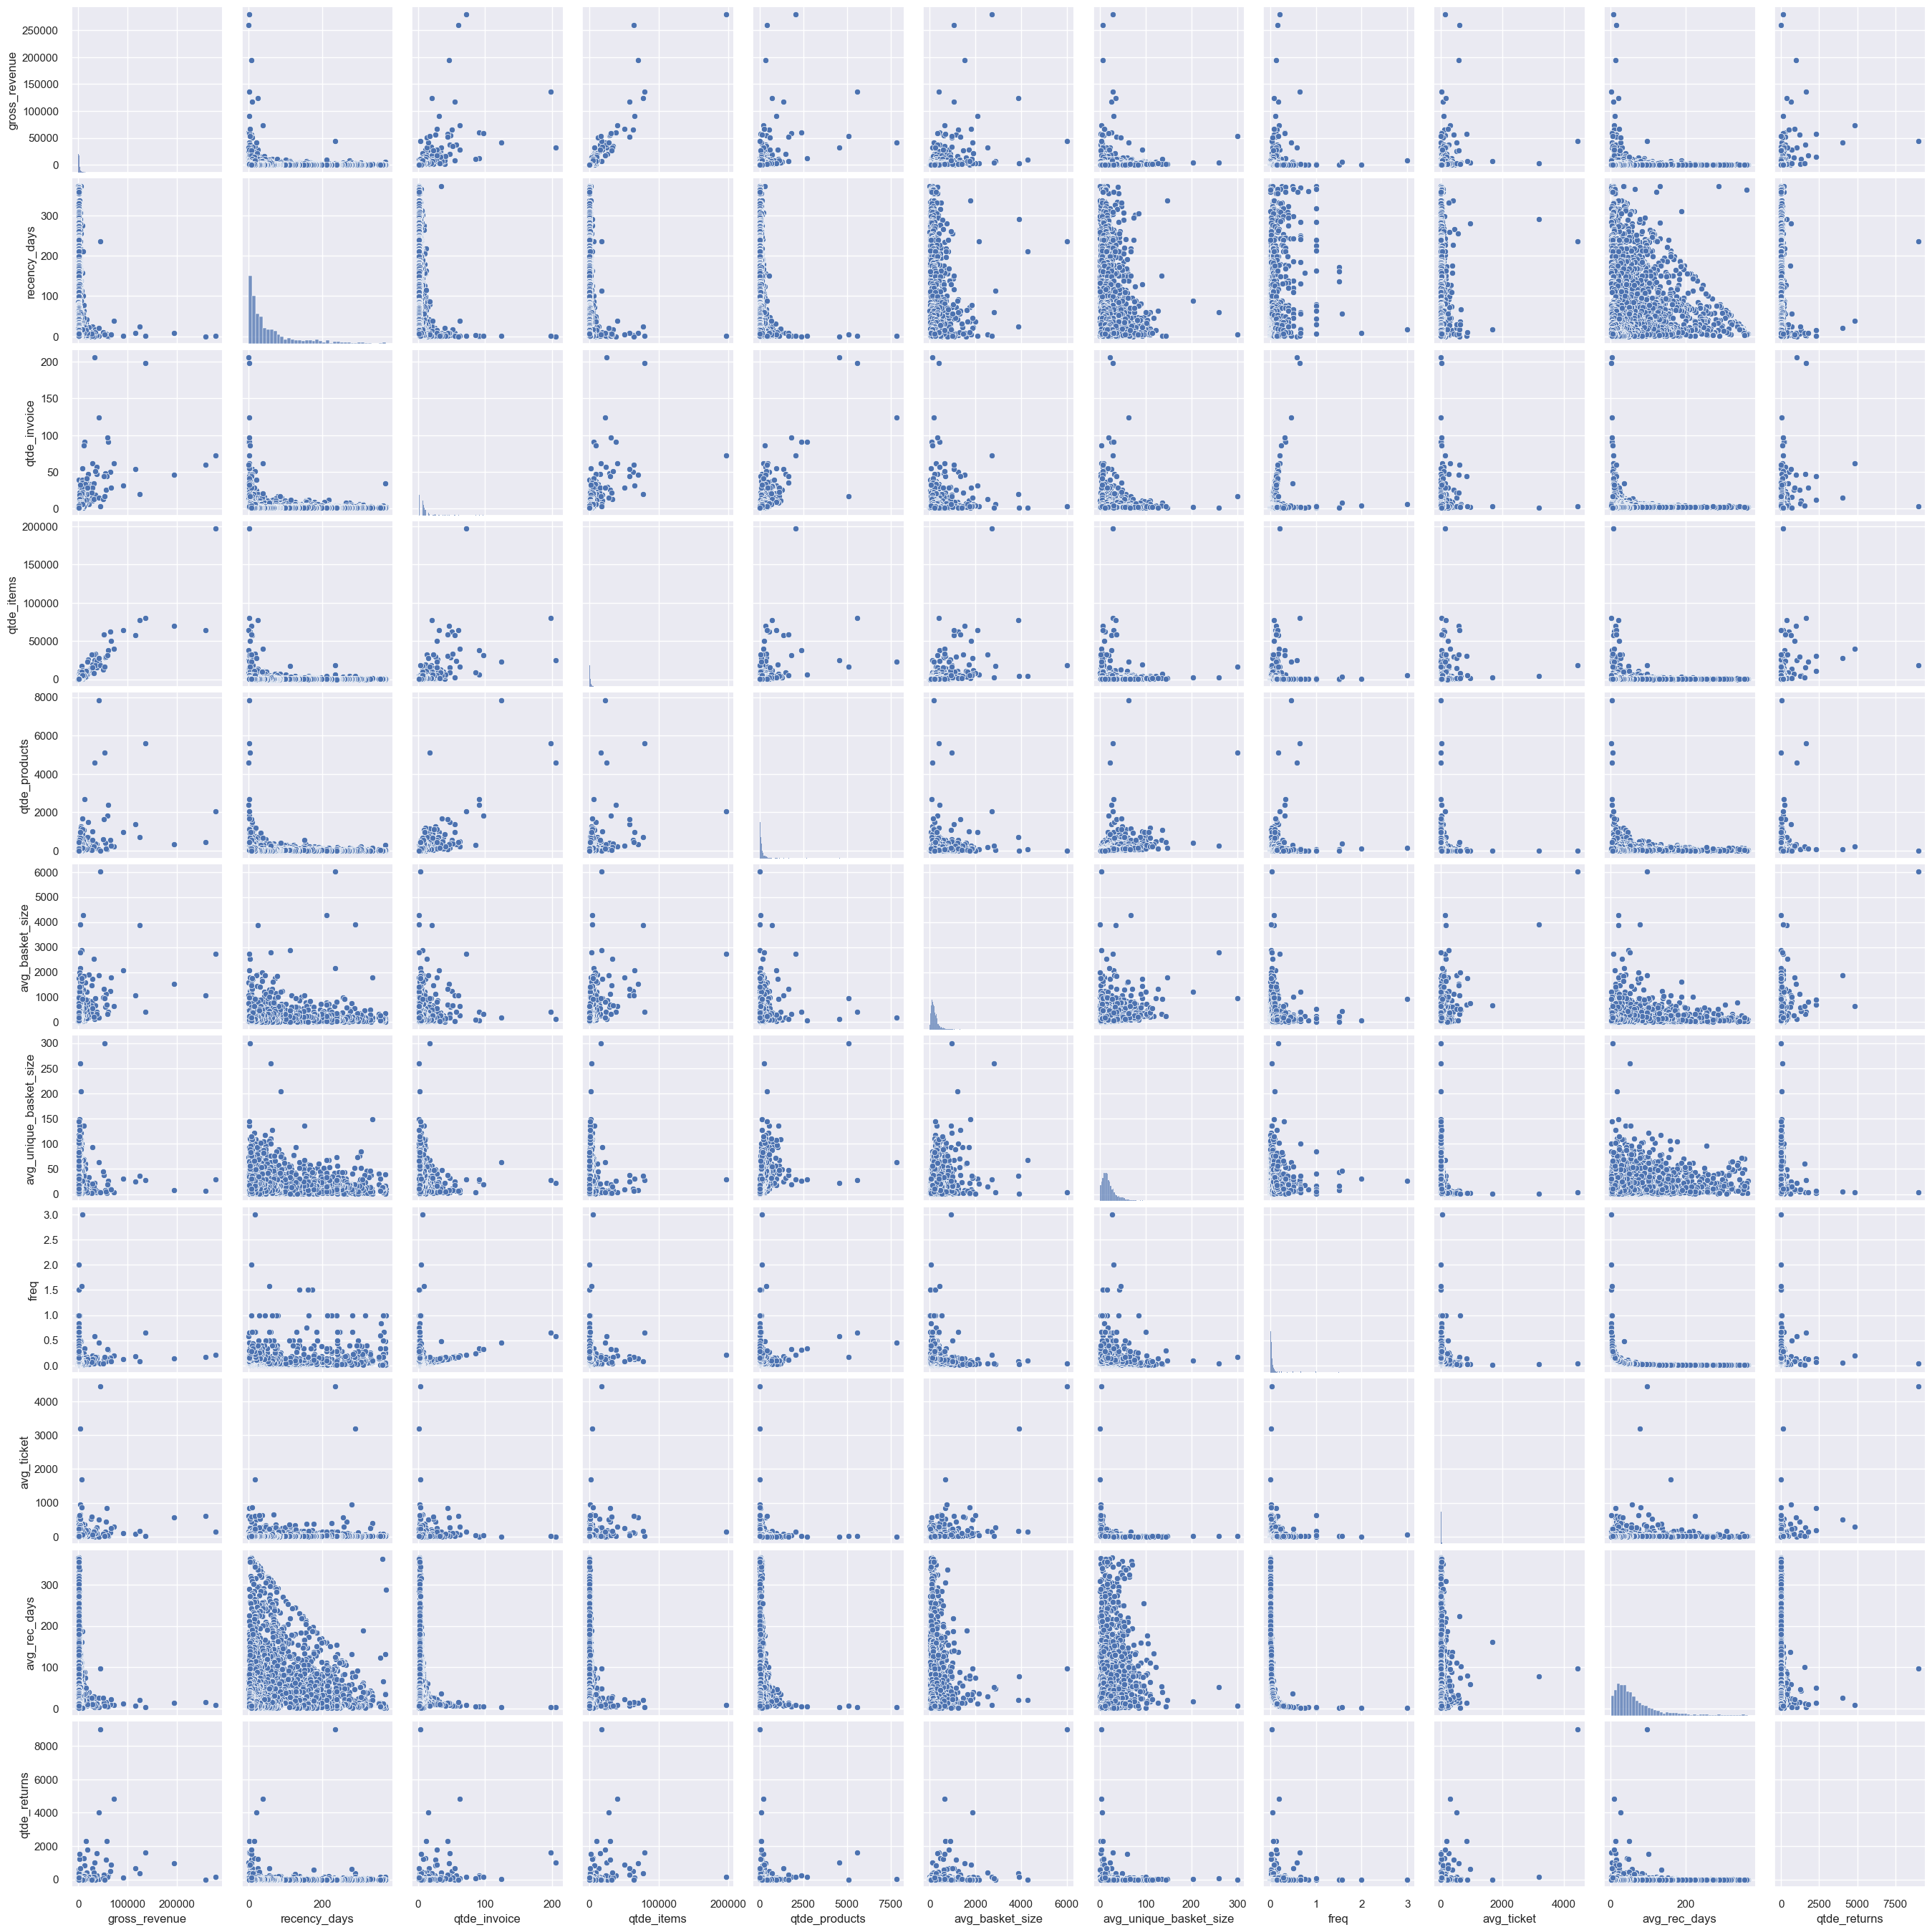

In [69]:
sns.pairplot(df_aux)

## Estudo do Espaço

In [71]:
ss = MinMaxScaler()

df_aux['gross_revenue'] = ss.fit_transform(df_aux[['gross_revenue']])
df_aux['recency_days'] = ss.fit_transform(df_aux[['recency_days']])
df_aux['qtde_invoice'] = ss.fit_transform(df_aux[['qtde_invoice']])
df_aux['qtde_items'] = ss.fit_transform(df_aux[['qtde_items']])
df_aux['qtde_products'] = ss.fit_transform(df_aux[['qtde_products']])
df_aux['avg_basket_size'] = ss.fit_transform(df_aux[['avg_basket_size']])
df_aux['avg_unique_basket_size'] = ss.fit_transform(df_aux[['avg_unique_basket_size']])
df_aux['freq'] = ss.fit_transform(df_aux[['freq']])
df_aux['avg_rec_days'] = ss.fit_transform(df_aux[['avg_rec_days']])
df_aux['qtde_returns'] = ss.fit_transform(df_aux[['qtde_returns']])
df_aux['avg_ticket'] = ss.fit_transform(df_aux[['avg_ticket']])

In [72]:
X = df_aux.copy()

### PCA

In [73]:
from sklearn import decomposition as  dcp

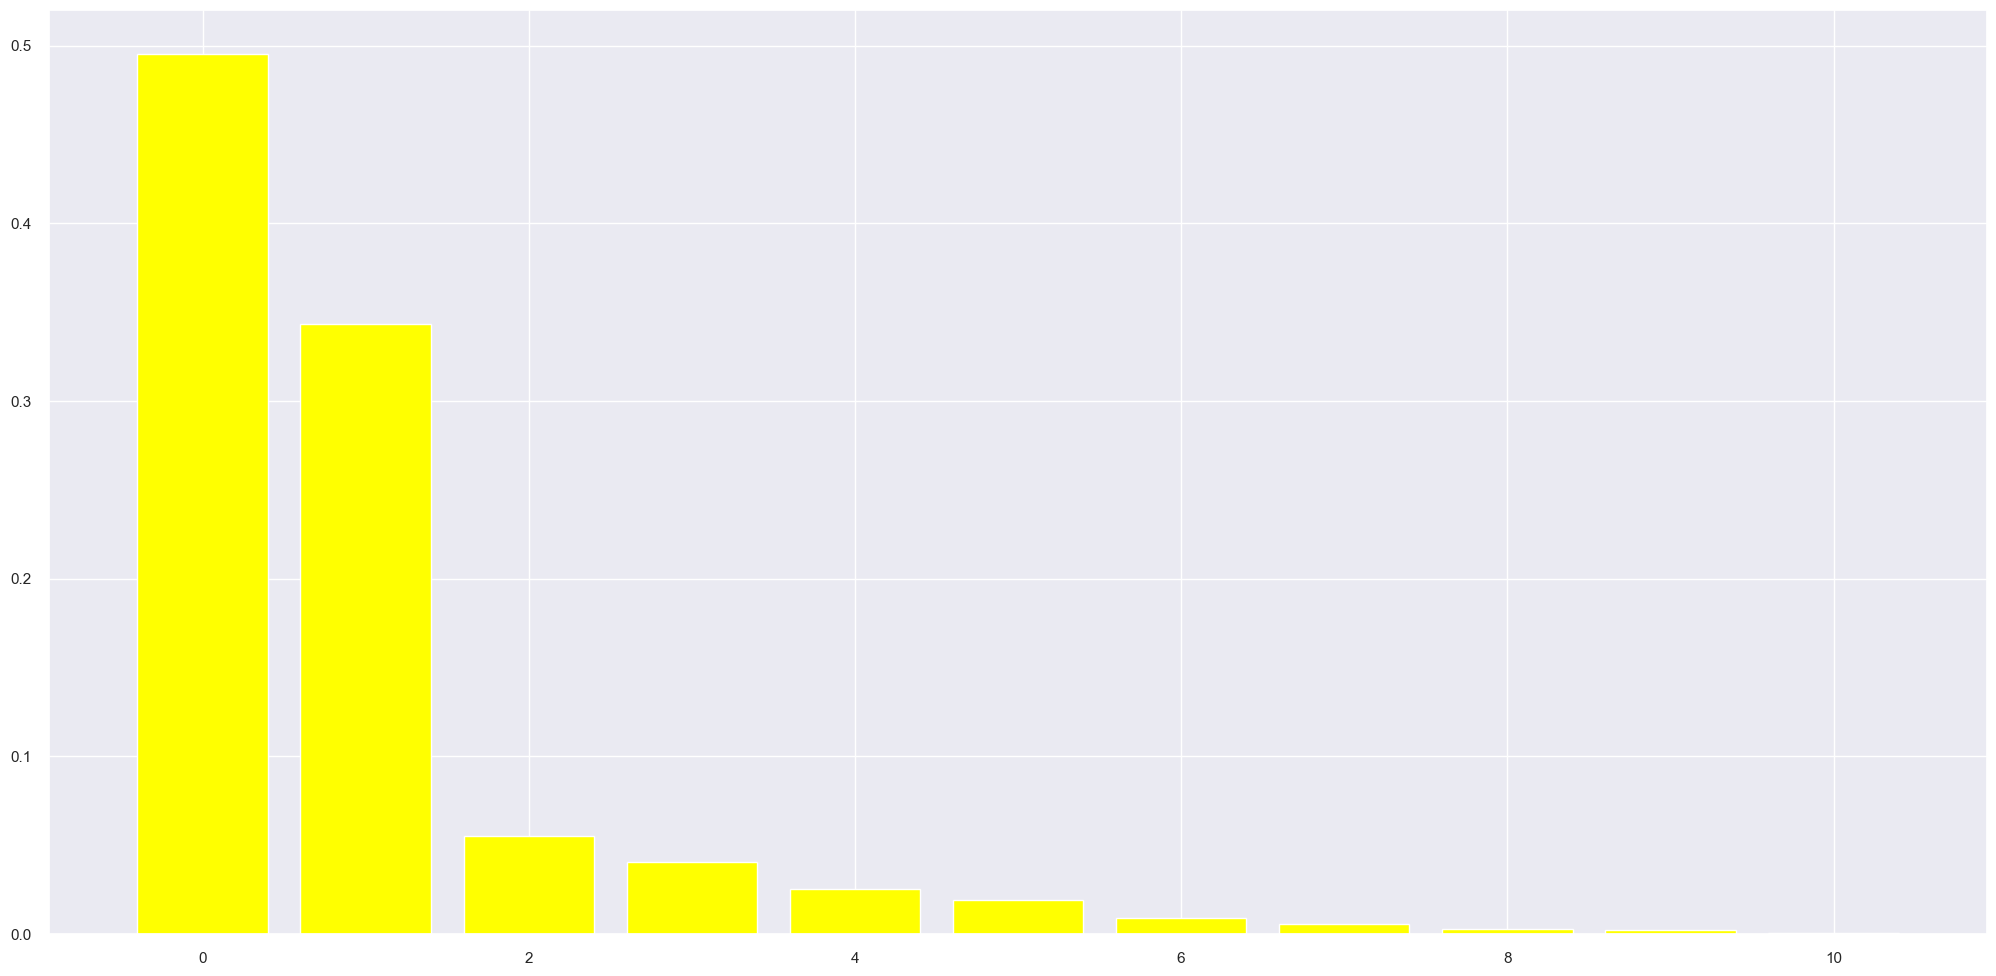

In [74]:
pca = dcp.PCA(n_components = X.shape[1])
principal_component = pca.fit_transform(X)

# plot explained variable

features = range(pca.n_components_)

plt.bar(features, pca.explained_variance_ratio_,color='yellow')

#pcs componentes
df_pca = pd.DataFrame(principal_component)

<AxesSubplot:xlabel='0', ylabel='1'>

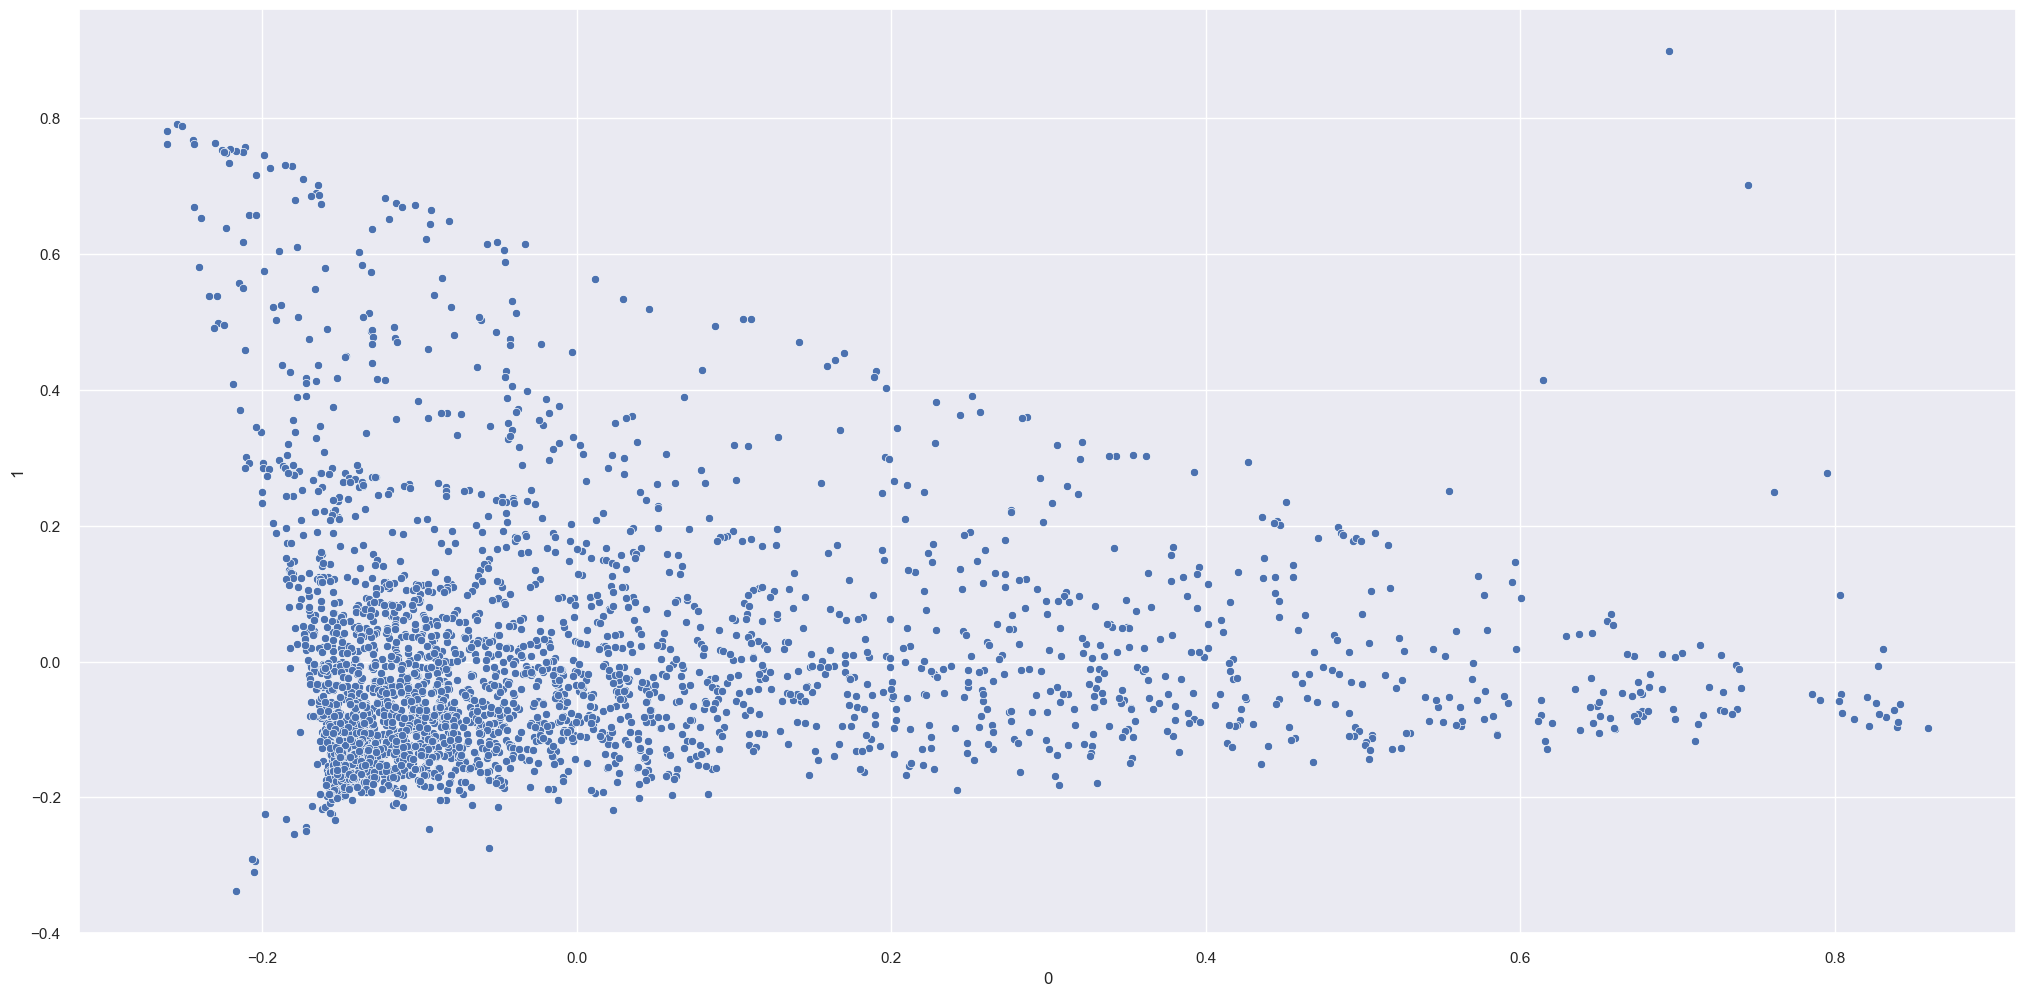

In [75]:
sns.scatterplot(x=0,y=1,data=df_pca)

### UMAP

<AxesSubplot:xlabel='embedding_x', ylabel='embedding_y'>

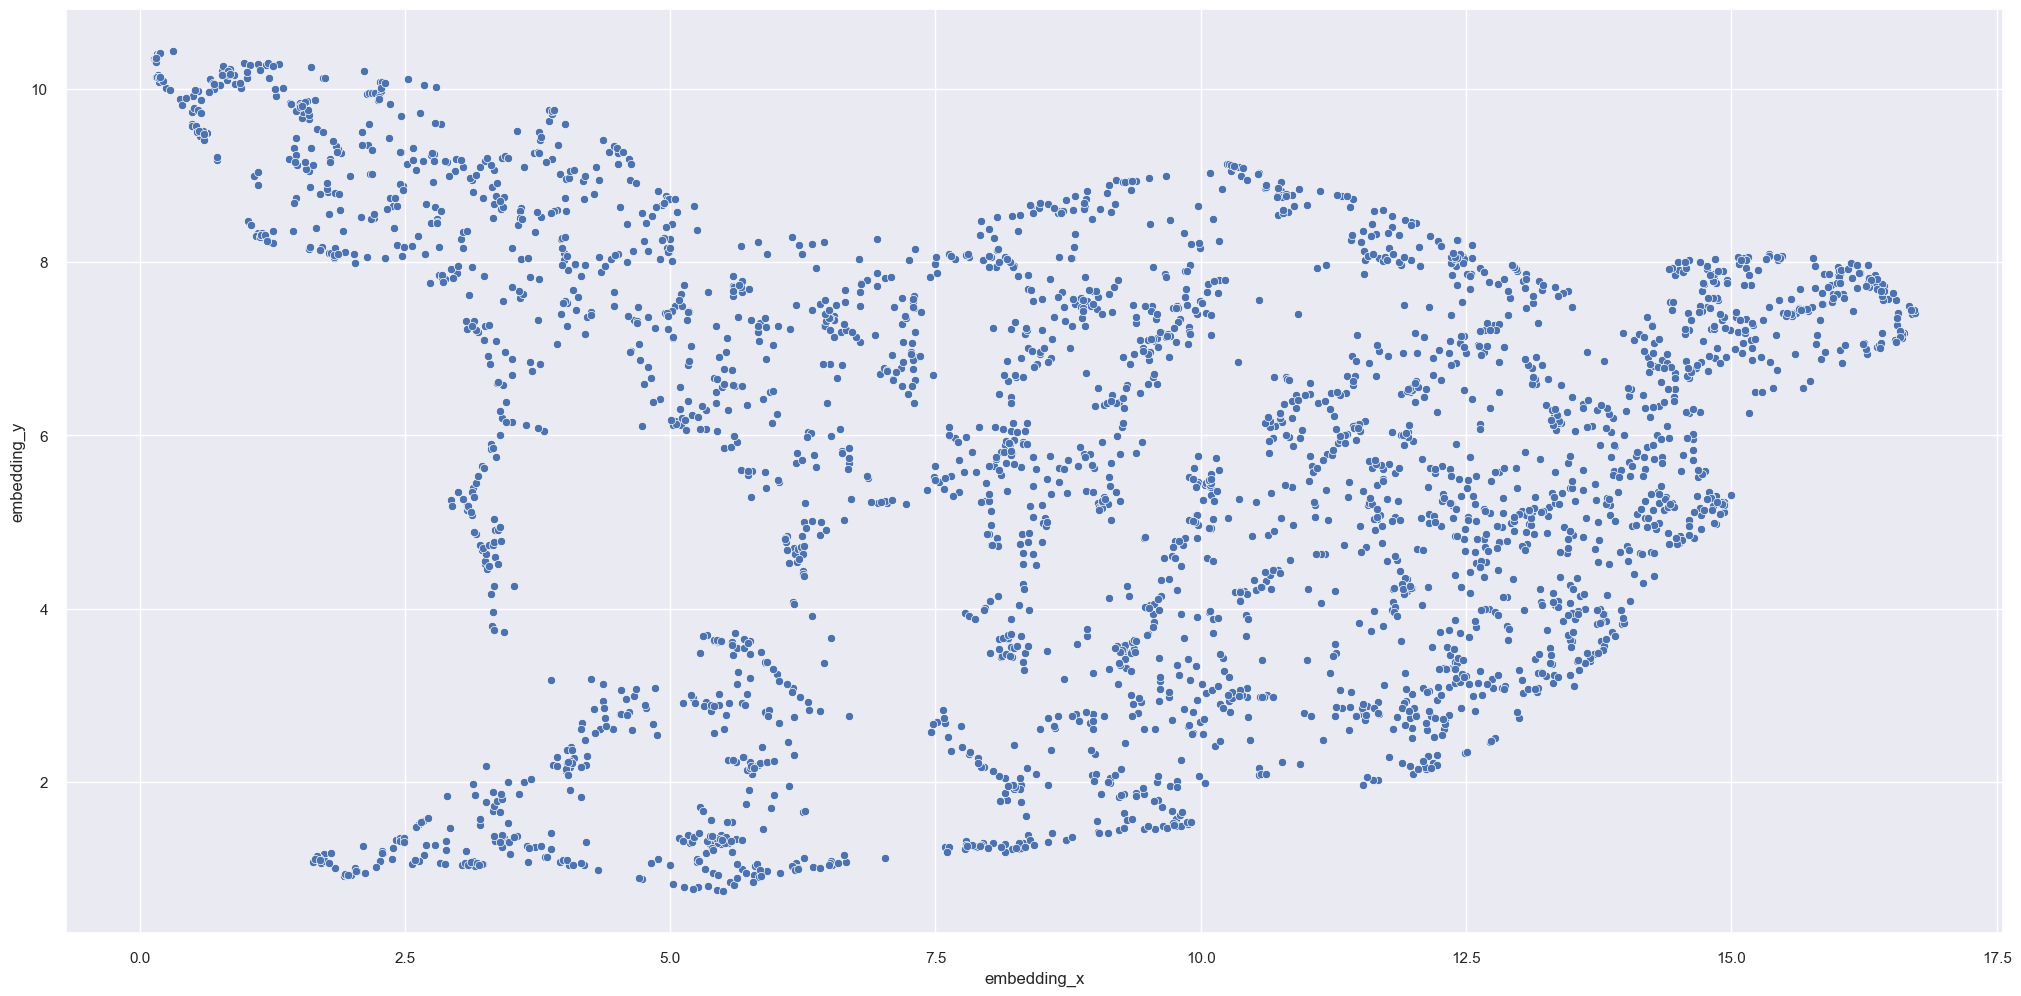

In [76]:
import umap.umap_ as umap
reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(X)


#embedding

df_pca['embedding_x'] = embedding[:,0]
df_pca['embedding_y'] = embedding[:,1]


sns.scatterplot(x='embedding_x', y ='embedding_y',data=df_pca)

### t-sne

C:\Users\Lavin\anaconda3\envs\insiders_clustering\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\Lavin\anaconda3\envs\insiders_clustering\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


<AxesSubplot:xlabel='embedding_x', ylabel='embedding_y'>

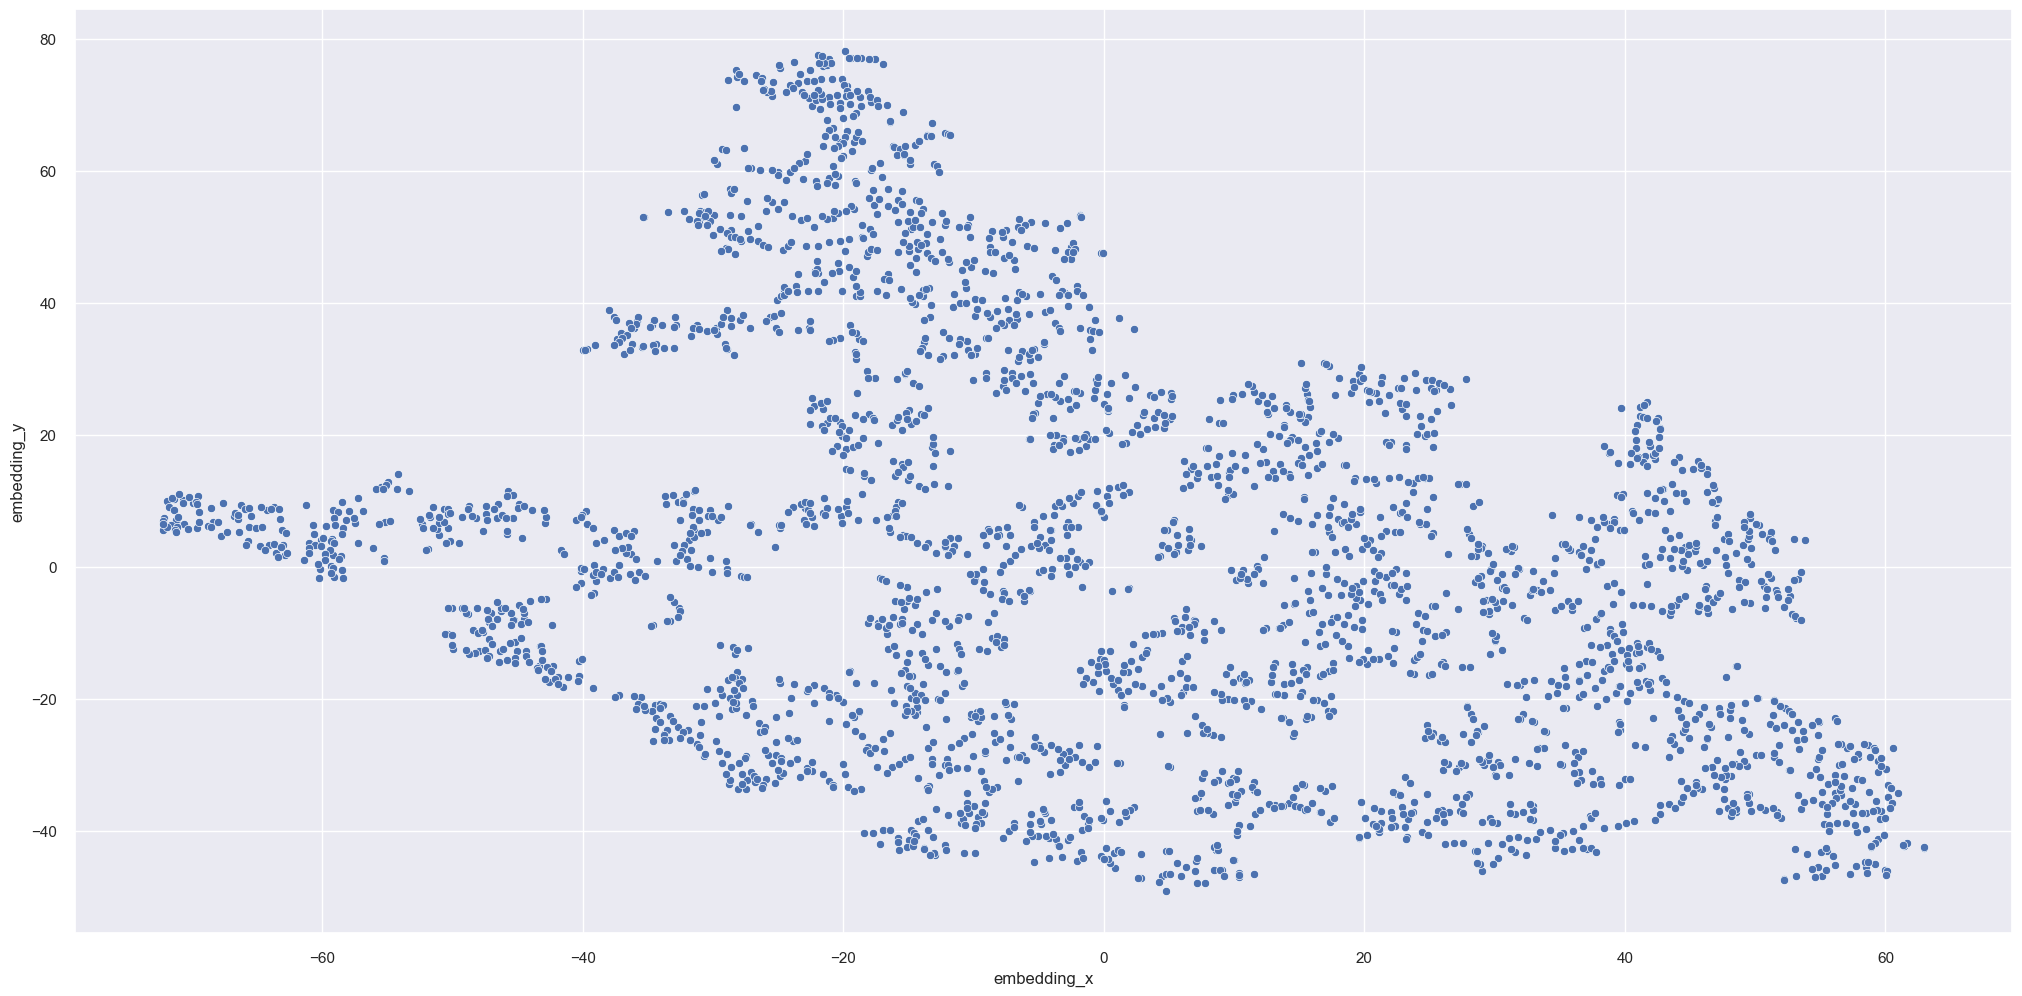

In [77]:
from sklearn.manifold import TSNE
reducer = TSNE(n_components=2,n_jobs=-1,random_state=42)
embedding = reducer.fit_transform(X)


#embedding

df_pca['embedding_x'] = embedding[:,0]
df_pca['embedding_y'] = embedding[:,1]


sns.scatterplot(x='embedding_x', y ='embedding_y',data=df_pca)

### Tree-based embedding

In [78]:
X = df5.drop(columns=['customer_id','gross_revenue'],axis=1)
y = df5['gross_revenue']


# model definition
rf_model = RandomForestRegressor(n_estimators=100,random_state=42)

#model training
rf_model.fit(X,y.values)

# Leaf
df_leaf = pd.DataFrame(rf_model.apply(X))
#dataframe Leaf

In [79]:
df_leaf.head()

0     1     2     3     4     5     6     7     8     9   ...    90  \
0  2995  2714  3383  3257  2767  3303  3254  3145  3172  3317  ...  3185   
1  2964  2931  3045  3019  2756  2971  2888  2835  3111  2944  ...  2546   
2  3636  3597  3575  3455  3550  3674  3611  3548  3669  3612  ...  3596   
3  1272  1422  1759  1500  1903  2079  2114  1996  1650  1728  ...  1855   
4   357   717   556   698   137   707   736   684   191   199  ...   740   

     91    92    93    94    95    96    97    98    99  
0  3171  3191  3071  3044  3115  3208  2825  3336  3358  
1  2871  2947  3019  3143  3064  2908  2802  2926  3004  
2  3440  3560  3584  3613  3447  3533  3585  3613  3648  
3  1746  2041  1890  1976  2311  1507  1198  2152  2117  
4   195   580   544   689   130   189   704   707   140  

[5 rows x 100 columns]

<AxesSubplot:xlabel='embedding_x', ylabel='embedding_y'>

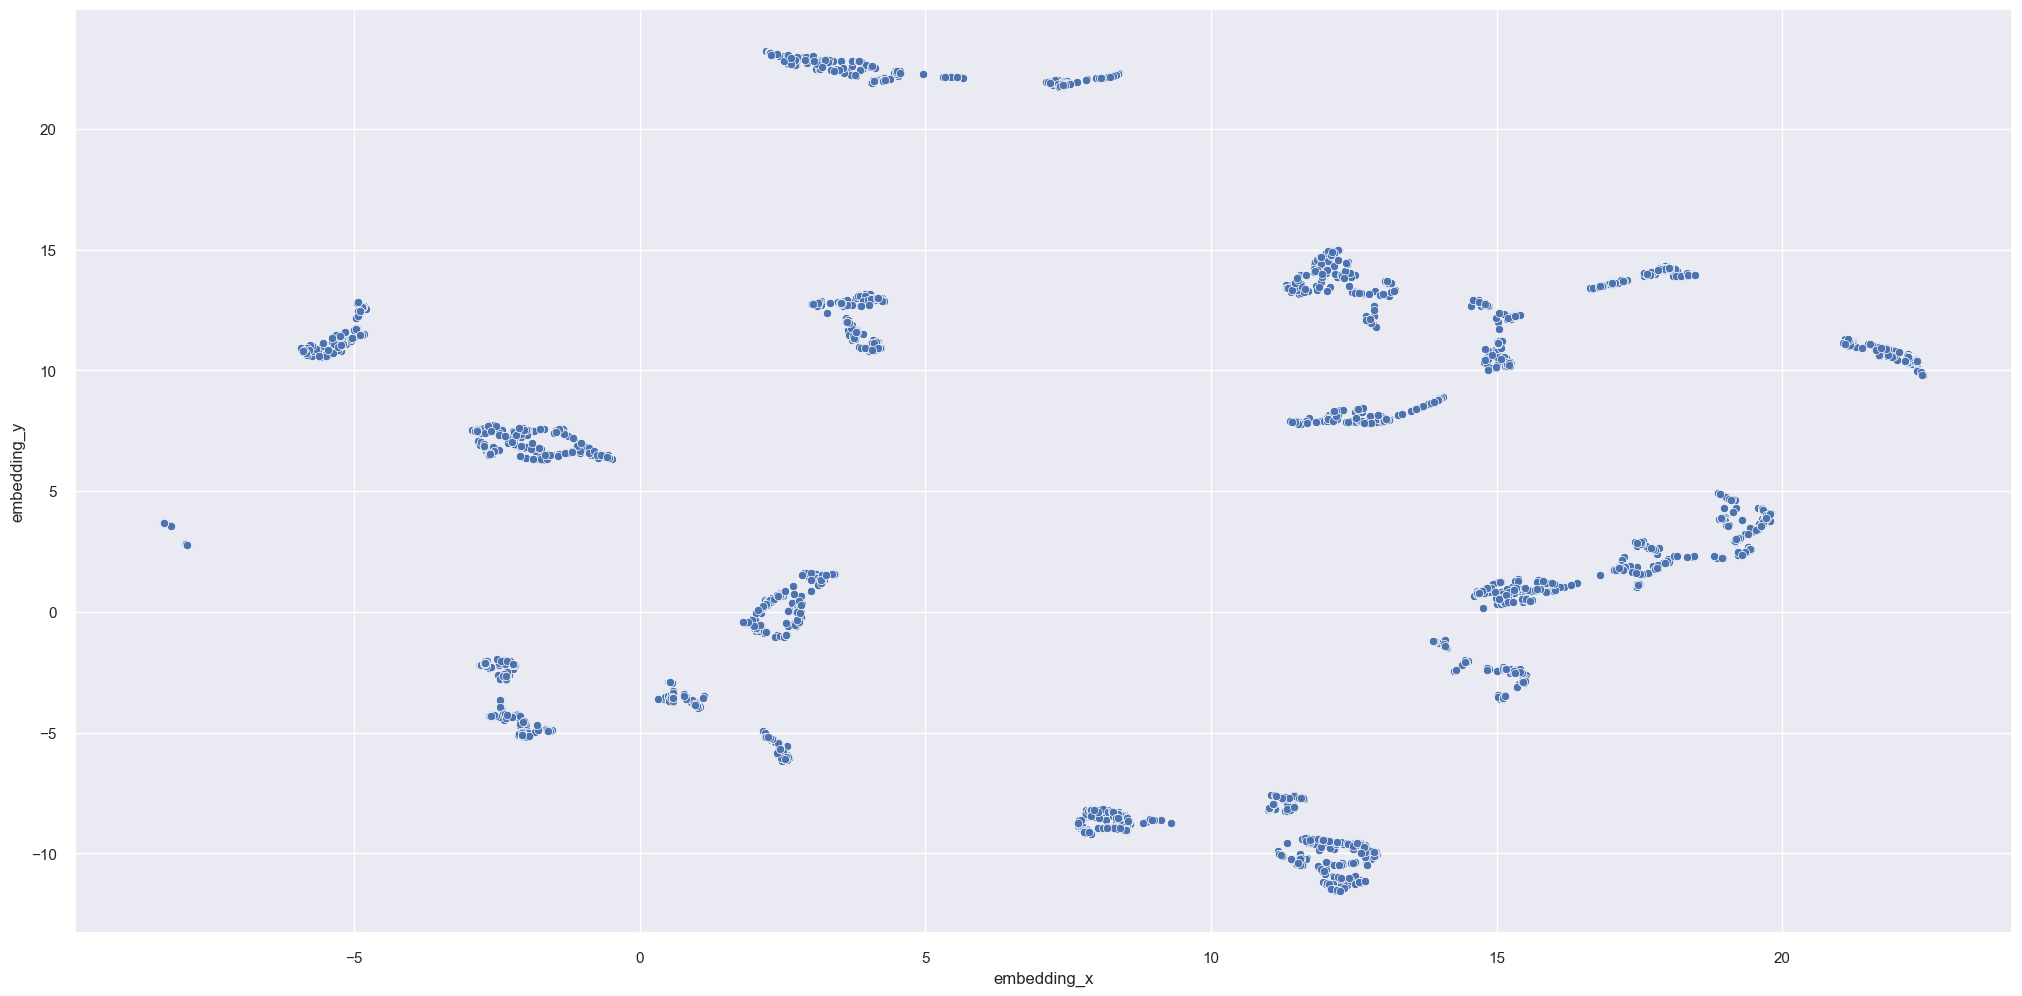

In [80]:
import umap.umap_ as umap
reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(df_leaf)


#embedding

df_pca['embedding_x'] = embedding[:,0]
df_pca['embedding_y'] = embedding[:,1]


sns.scatterplot(x='embedding_x', y ='embedding_y',data=df_pca)

# Data preparation

In [81]:
df6 = df5.copy()

In [82]:
df6.head()

customer_id  gross_revenue  recency_days  qtde_invoice  qtde_items  \
0      17850.0        5391.21         372.0          34.0      1733.0   
1      13047.0        3232.59          56.0           9.0      1390.0   
2      12583.0        6705.38           2.0          15.0      5028.0   
3      13748.0         948.25          95.0           5.0       439.0   
4      15100.0         876.00         333.0           3.0        80.0   

   qtde_products  avg_basket_size  avg_unique_basket_size      freq  \
0          297.0        50.970588                8.735294  0.486111   
1          171.0       154.444444               19.000000  0.048780   
2          232.0       335.200000               15.466667  0.045699   
3           28.0        87.800000                5.600000  0.017921   
4            3.0        26.666667                1.000000  0.136364   

   avg_ticket  avg_rec_days  qtde_returns  
0   18.152222     35.500000          21.0  
1   18.904035     27.250000           6.0  
2   28.902500     23.187500          50.0  
3   33.866071     92.666667           0.0  
4  292.000000      8.600000          22.0

In [83]:
from sklearn.preprocessing import StandardScaler

In [84]:
ss = MinMaxScaler()

df6['gross_revenue'] = ss.fit_transform(df6[['gross_revenue']])
df6['recency_days'] = ss.fit_transform(df6[['recency_days']])
df6['qtde_invoice'] = ss.fit_transform(df6[['qtde_invoice']])
df6['qtde_items'] = ss.fit_transform(df6[['qtde_items']])
df6['qtde_products'] = ss.fit_transform(df6[['qtde_products']])
df6['avg_basket_size'] = ss.fit_transform(df6[['avg_basket_size']])
df6['avg_unique_basket_size'] = ss.fit_transform(df6[['avg_unique_basket_size']])
df6['freq'] = ss.fit_transform(df6[['freq']])
df6['avg_rec_days'] = ss.fit_transform(df6[['avg_rec_days']])
df6['qtde_returns'] = ss.fit_transform(df6[['qtde_returns']])
df6['avg_ticket'] = ss.fit_transform(df6[['avg_ticket']])

# df_aux['gross_revenue'] = ss.fit_transform(df_aux[['gross_revenue']])
# df_aux['recency_days'] = ss.fit_transform(df_aux[['recency_days']])
# df_aux['qtde_invoice'] = ss.fit_transform(df_aux[['qtde_invoice']])
# df_aux['qtde_items'] = ss.fit_transform(df_aux[['qtde_items']])
# df_aux['qtde_products'] = ss.fit_transform(df_aux[['qtde_products']])
# df_aux['avg_basket_size'] = ss.fit_transform(df_aux[['avg_basket_size']])
# df_aux['avg_unique_basket_size'] = ss.fit_transform(df_aux[['avg_unique_basket_size']])
# df_aux['freq'] = ss.fit_transform(df_aux[['freq']])
# df_aux['avg_rec_days'] = ss.fit_transform(df_aux[['avg_rec_days']])
# df_aux['qtde_returns'] = ss.fit_transform(df_aux[['qtde_returns']])
# df_aux['avg_ticket'] = ss.fit_transform(df_aux[['avg_ticket']])

In [85]:
df6.head()

customer_id  gross_revenue  recency_days  qtde_invoice  qtde_items  \
0      17850.0       0.019292      0.997319      0.160976    0.008799   
1      13047.0       0.011559      0.150134      0.039024    0.007056   
2      12583.0       0.024000      0.005362      0.068293    0.025538   
3      13748.0       0.003375      0.254692      0.019512    0.002225   
4      15100.0       0.003116      0.892761      0.009756    0.000401   

   qtde_products  avg_basket_size  avg_unique_basket_size      freq  \
0       0.037774         0.008317                0.025896  0.160512   
1       0.021695         0.025539                0.060260  0.014470   
2       0.029479         0.055623                0.048431  0.013441   
3       0.003446         0.014447                0.015400  0.004165   
4       0.000255         0.004272                0.000000  0.043717   

   avg_ticket  avg_rec_days  qtde_returns  
0    0.003595      0.094521      0.002330  
1    0.003764      0.071918      0.000666  
2    0.006010      0.060788      0.005547  
3    0.007125      0.251142      0.000000  
4    0.065116      0.020822      0.002441

# Feature selection

In [86]:
df7 = df6.copy()

# Fine tunning

In [87]:
X = df7.drop(columns='customer_id')

In [88]:
X.head()

gross_revenue  recency_days  qtde_invoice  qtde_items  qtde_products  \
0       0.019292      0.997319      0.160976    0.008799       0.037774   
1       0.011559      0.150134      0.039024    0.007056       0.021695   
2       0.024000      0.005362      0.068293    0.025538       0.029479   
3       0.003375      0.254692      0.019512    0.002225       0.003446   
4       0.003116      0.892761      0.009756    0.000401       0.000255   

   avg_basket_size  avg_unique_basket_size      freq  avg_ticket  \
0         0.008317                0.025896  0.160512    0.003595   
1         0.025539                0.060260  0.014470    0.003764   
2         0.055623                0.048431  0.013441    0.006010   
3         0.014447                0.015400  0.004165    0.007125   
4         0.004272                0.000000  0.043717    0.065116   

   avg_rec_days  qtde_returns  
0      0.094521      0.002330  
1      0.071918      0.000666  
2      0.060788      0.005547  
3      0.251142      0.000000  
4      0.020822      0.002441

In [89]:
clusters = [2,3,4,5,6,7]

## K-means

In [90]:
sil_k = []
for k in clusters:
    # model definition
    k_model = c.KMeans(n_clusters=k)

    #model training
    k_model.fit(X)

    #model predict
    labels = k_model.predict(X)

    #model performace
    sil_k.append(m.silhouette_score(X,labels,metric='euclidean'))

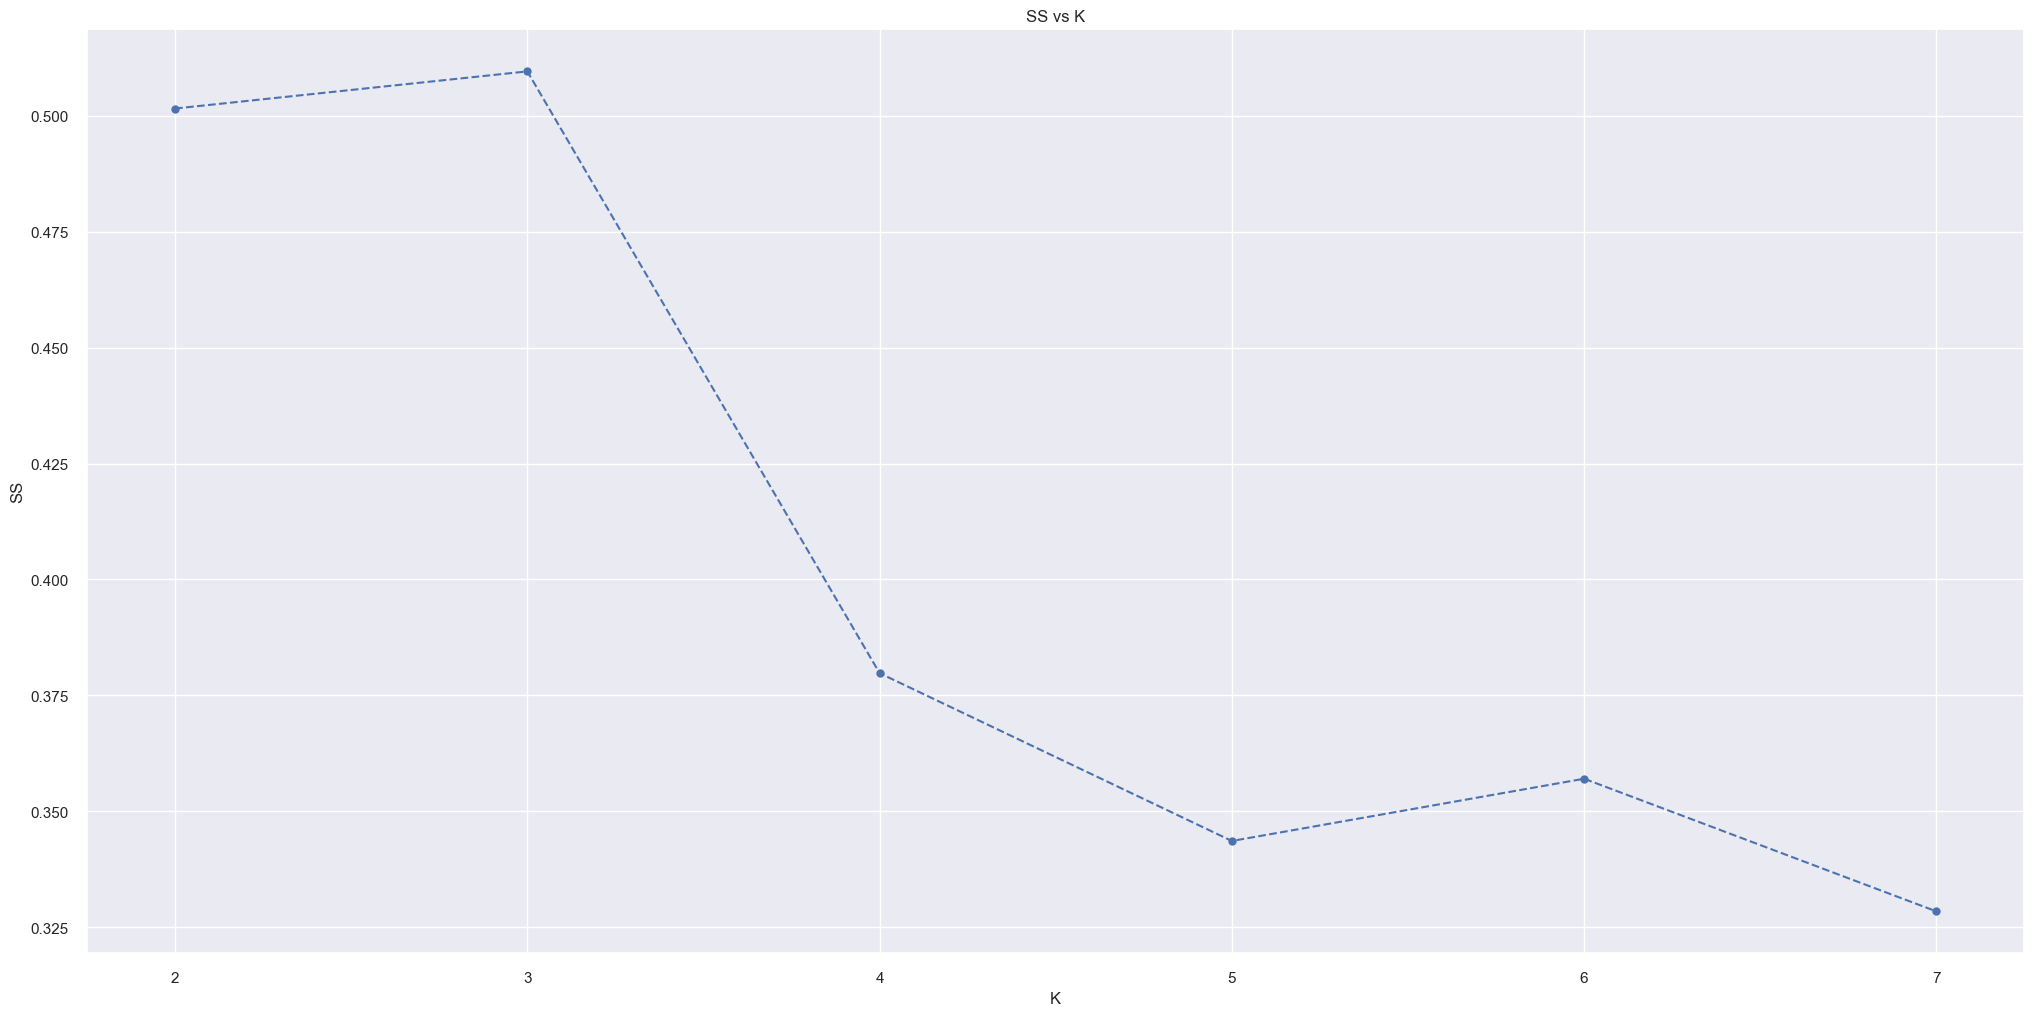

In [91]:
plt.plot(clusters,sil_k,linestyle='--',marker = 'o');
plt.xlabel('K');
plt.ylabel('SS');
plt.title('SS vs K');

## GMM

In [92]:
from sklearn import  mixture as mx

AIC - ajuste do modelo
BIC - ajuste dos parametros

In [95]:
gmm_k = []
for k in clusters:
    # model definition
    gmm_model = mx.GaussianMixture(n_components=k)

    #model training
    gmm_model.fit(X)

    #model predict
    labels = gmm_model.predict(X)

    #model performace
    gmm_k.append(m.silhouette_score(X,labels,metric='euclidean'))

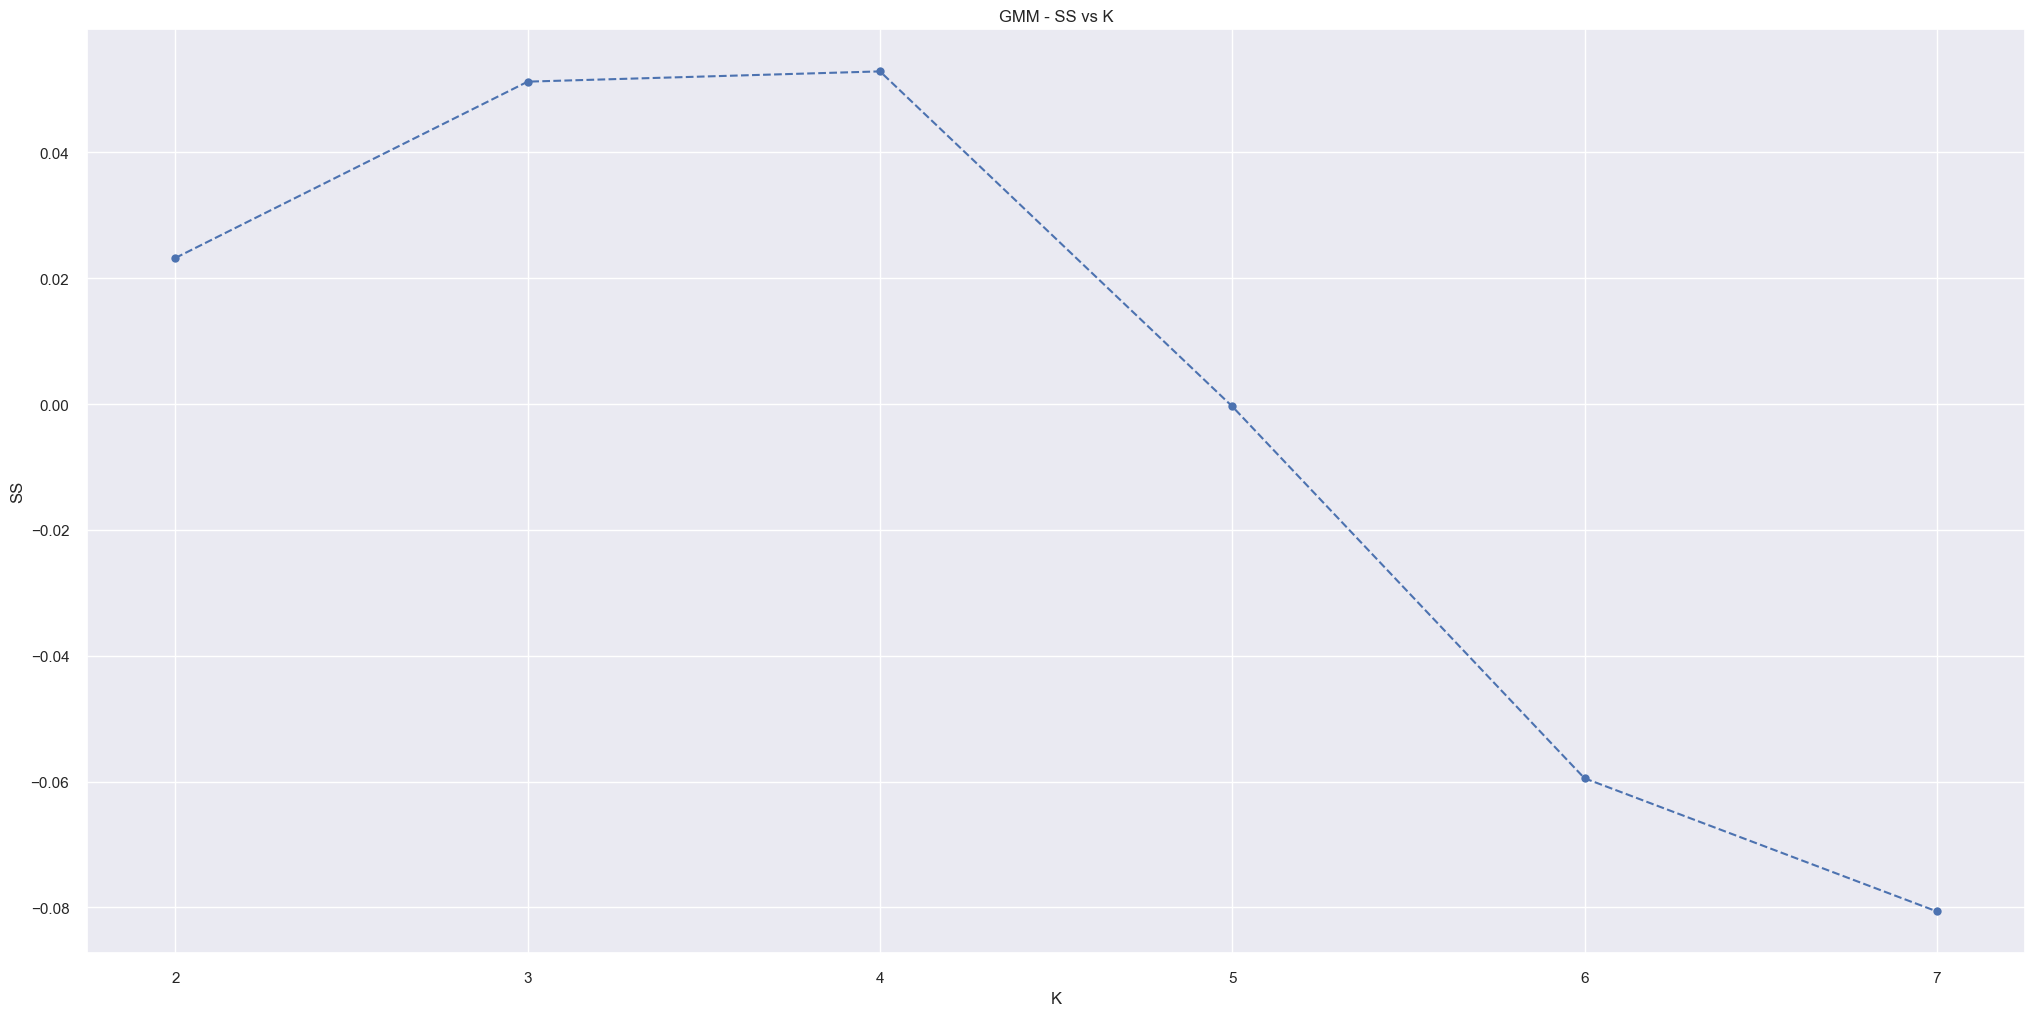

In [96]:
plt.plot(clusters,gmm_k,linestyle='--',marker = 'o');
plt.xlabel('K');
plt.ylabel('SS');
plt.title('GMM - SS vs K');

## H-Clustering

In [97]:
from scipy.cluster import hierarchy as hr

In [98]:
hc_model = hr.linkage(X,'ward')

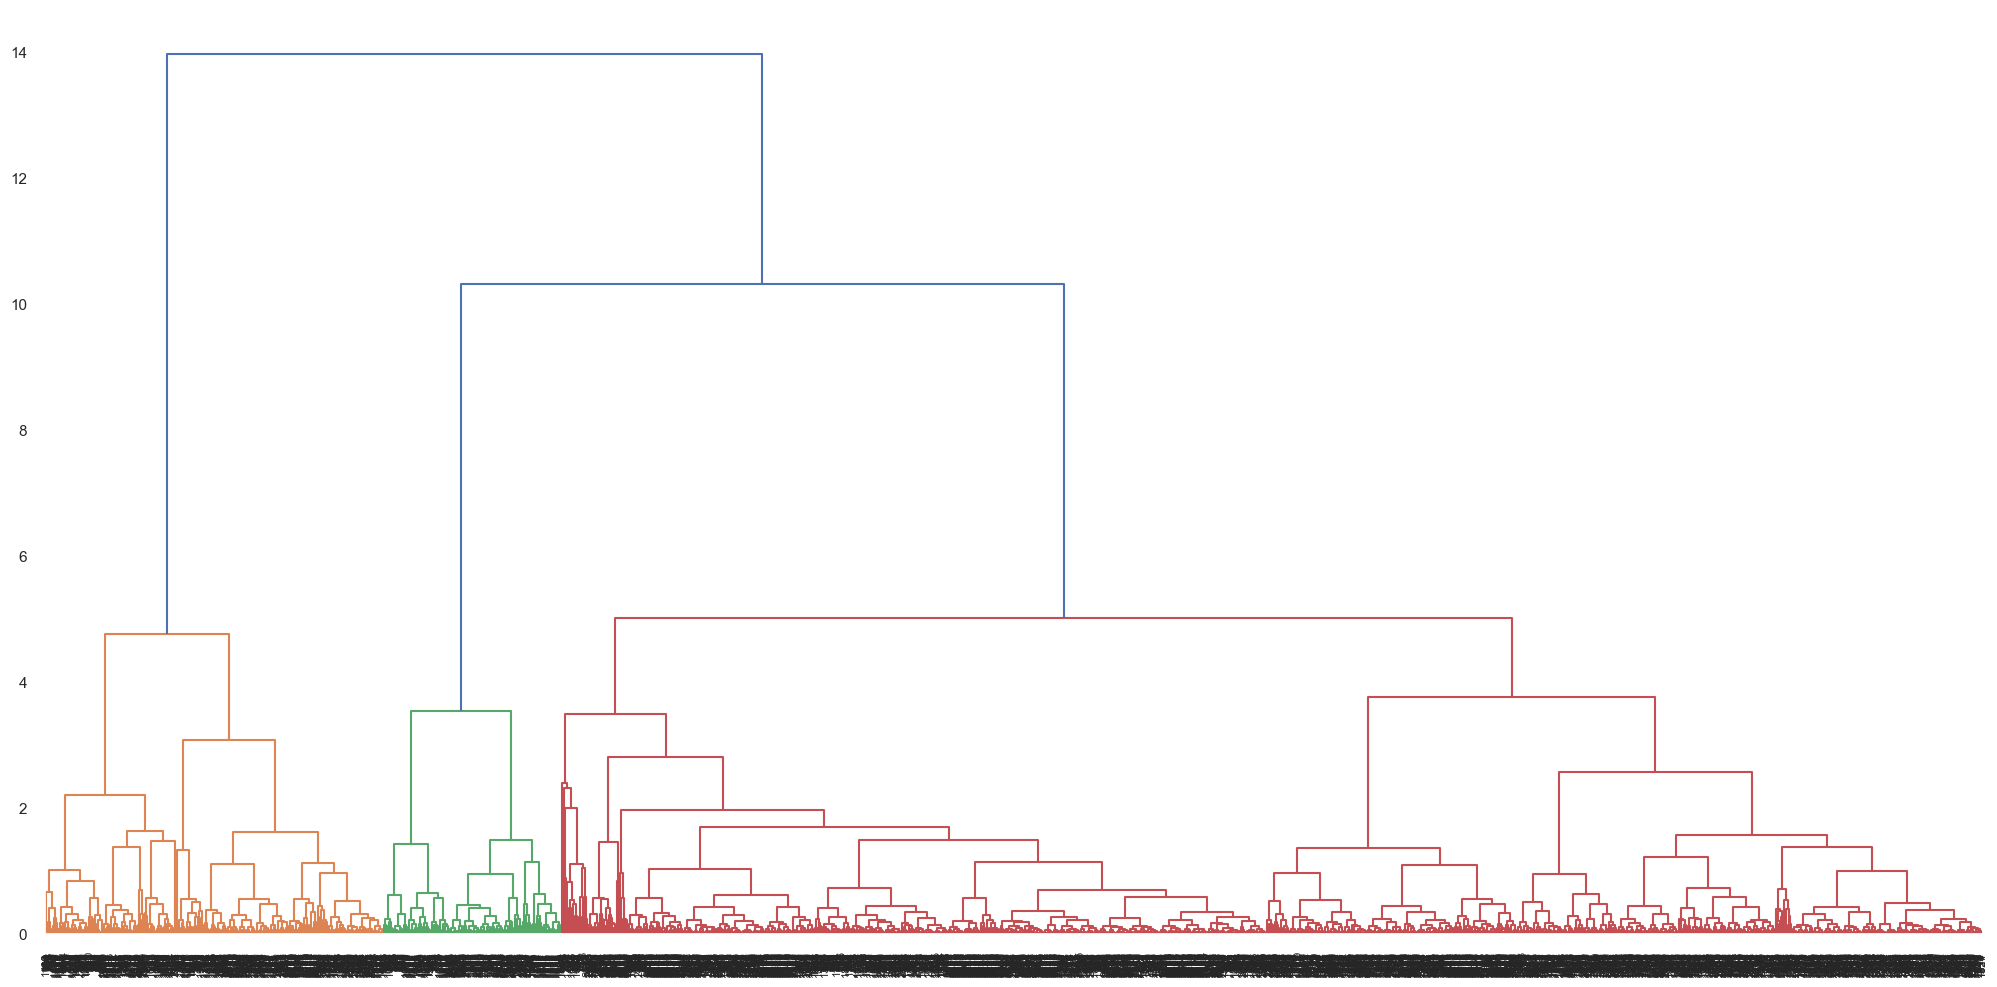

In [99]:
hr.dendrogram(hc_model,
             leaf_rotation=90,
             leaf_font_size=8)
plt.plot();

[]

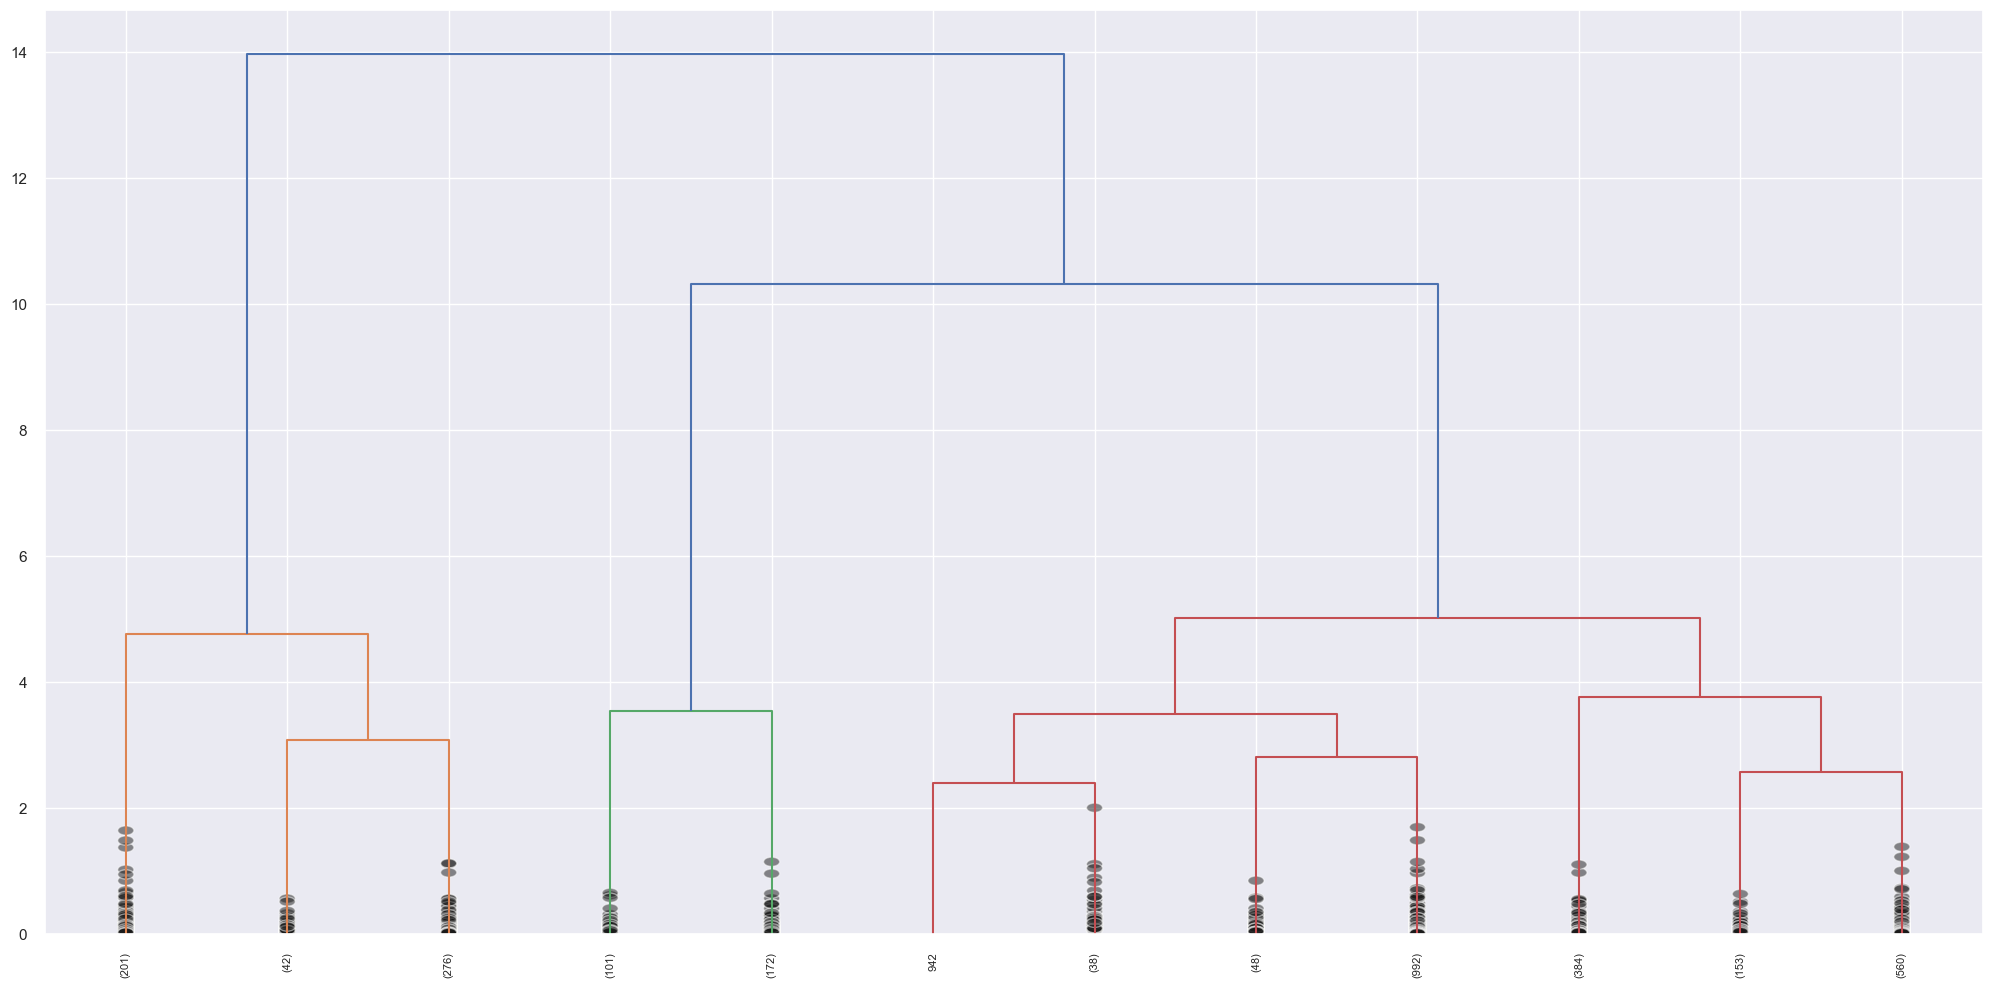

In [101]:
hr.dendrogram(hc_model,
              truncate_mode='lastp',
              p=12,
              leaf_rotation=90,
              leaf_font_size=8,
             show_contracted=True)
plt.plot()

In [102]:
hc_k = []
for k in clusters:
    # model definition
    hc_model = hr.linkage(X,'ward')

    #model predict
    labels = hr.fcluster(hc_model,k,criterion='maxclust')

    #model performace
    hc_k.append(m.silhouette_score(X,labels,metric='euclidean'))

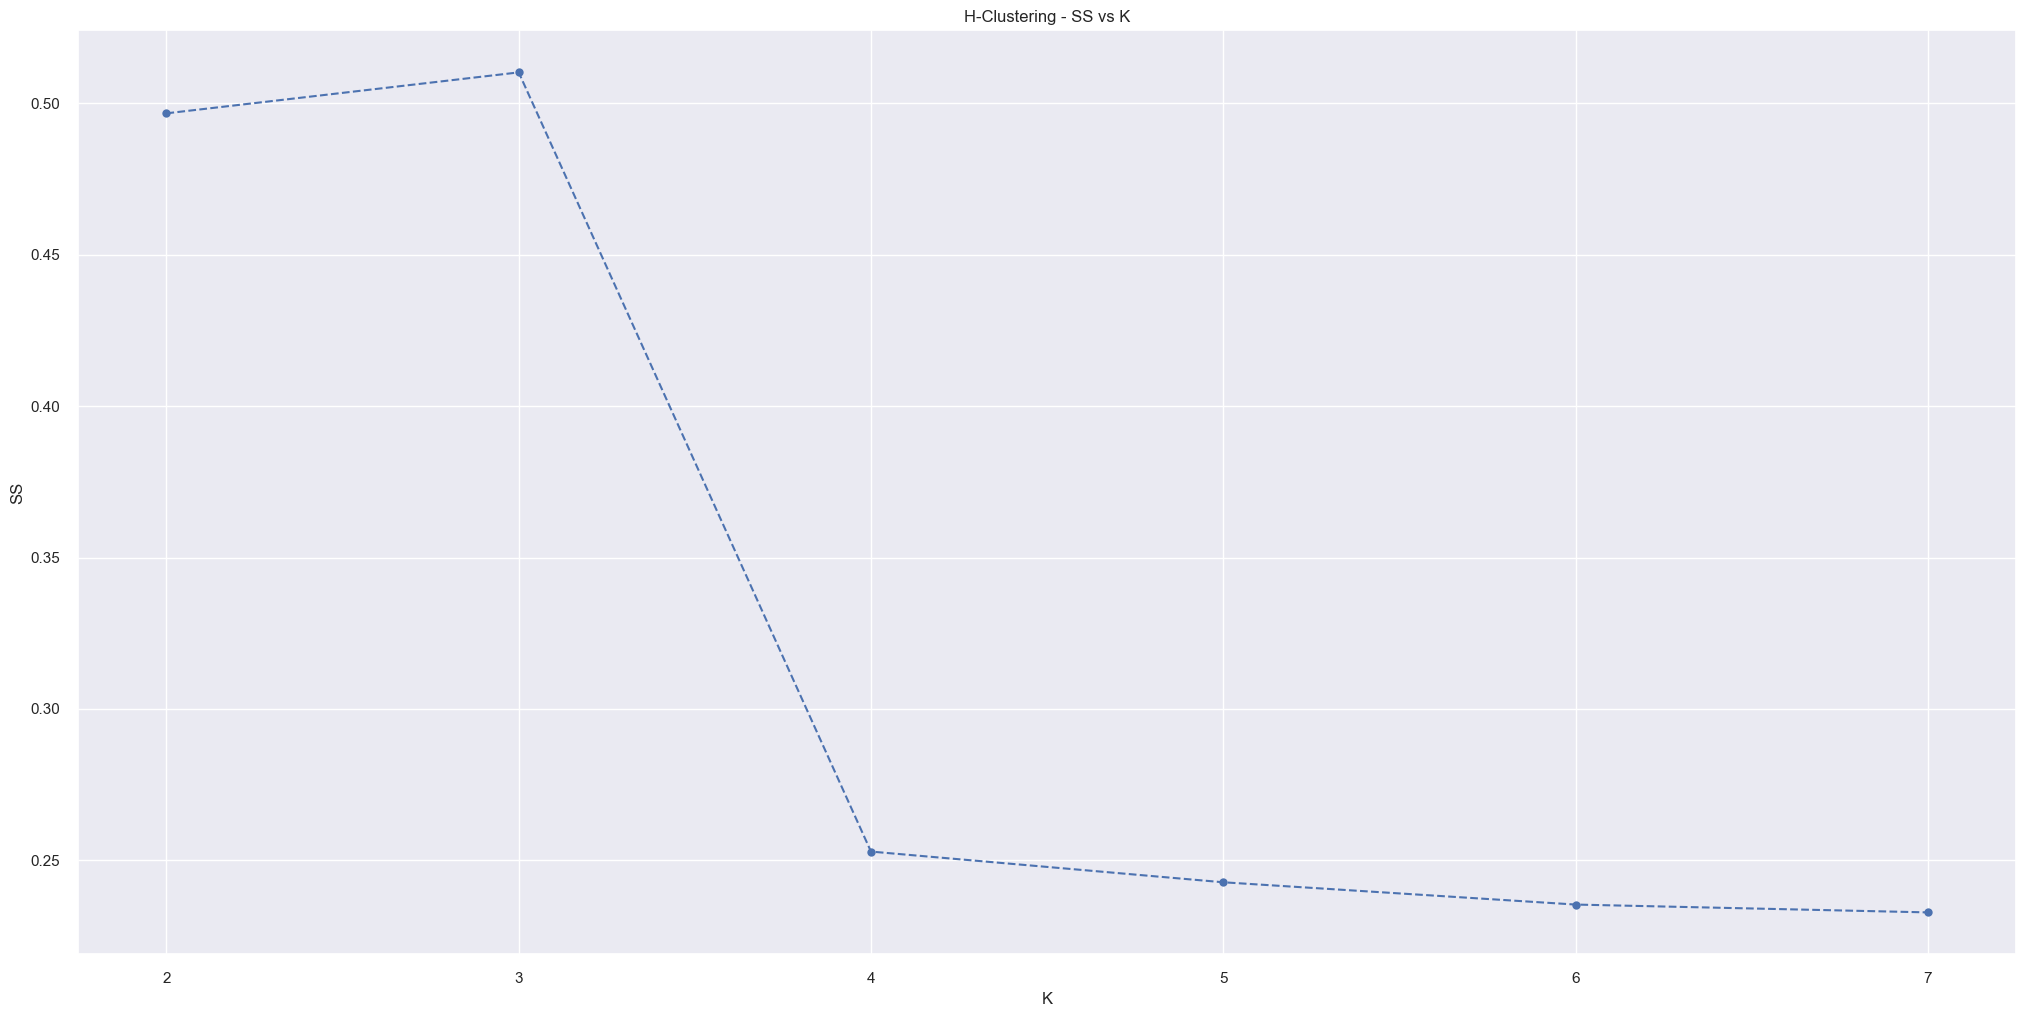

In [103]:
plt.plot(clusters,hc_k,linestyle='--',marker = 'o');
plt.xlabel('K');
plt.ylabel('SS');
plt.title('H-Clustering - SS vs K');

## DBSCAN

In [104]:
eps=0.2
min_samples = 20
#model training e predict
dbscan_model = c.DBSCAN(eps=eps,min_samples=min_samples)

#model training e predict
labels = dbscan_model.fit_predict(X)

db_k = m.silhouette_score(X,labels,metric='euclidean')

In [105]:
from sklearn.neighbors import NearestNeighbors

In [106]:
nei = NearestNeighbors(n_neighbors=min_samples).fit(X)
dist, indi = nei.kneighbors(X)

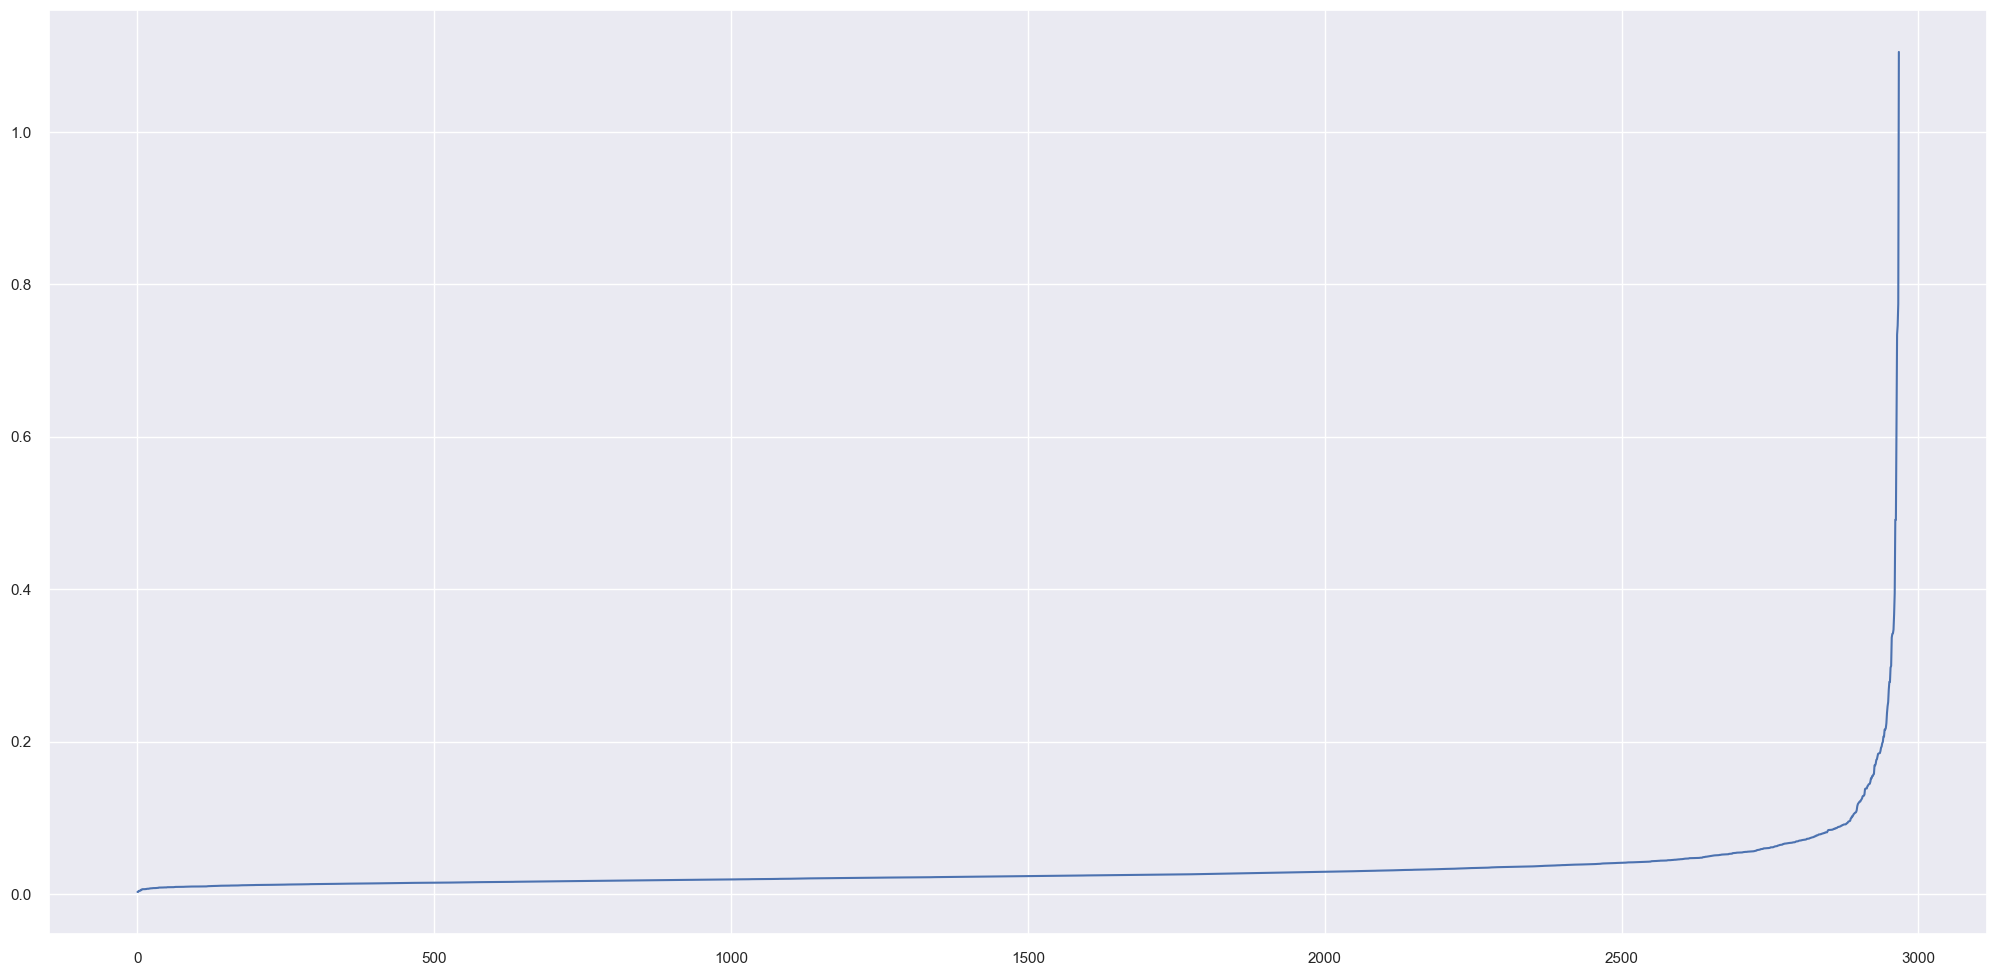

In [107]:
dist = np.sort(dist,axis=0)
dist = dist[:,1]
plt.plot(dist);

In [108]:
db_k = [db_k,0.00,0.00,0.00,0.00,0.00]

## Results

In [109]:
# Model name | k=2 | k=3 | k=4 | k=5
# Kmeans        ss    ss    ss    ss
# GMM           ss    ss    ss    ss
# HC            ss    ss    ss    ss
# DBSCAN        ss    ss    ss    ss

df_results = pd.DataFrame({
    'Kmeans': sil_k,
    'GMM': gmm_k,
    'HC': hc_k,
    'DBSCAN': db_k
}).T
df_results.columns = clusters
df_results.style.highlight_max(color='lightgreen',axis=1)

## Silhouete analisys

For K = 2 Silhouette: 0.49670681592444443
For K = 3 Silhouette: 0.5102306493259474
For K = 4 Silhouette: 0.252876594354338
For K = 5 Silhouette: 0.24273752210459265
For K = 6 Silhouette: 0.2353782478689408
For K = 7 Silhouette: 0.23279098825261252


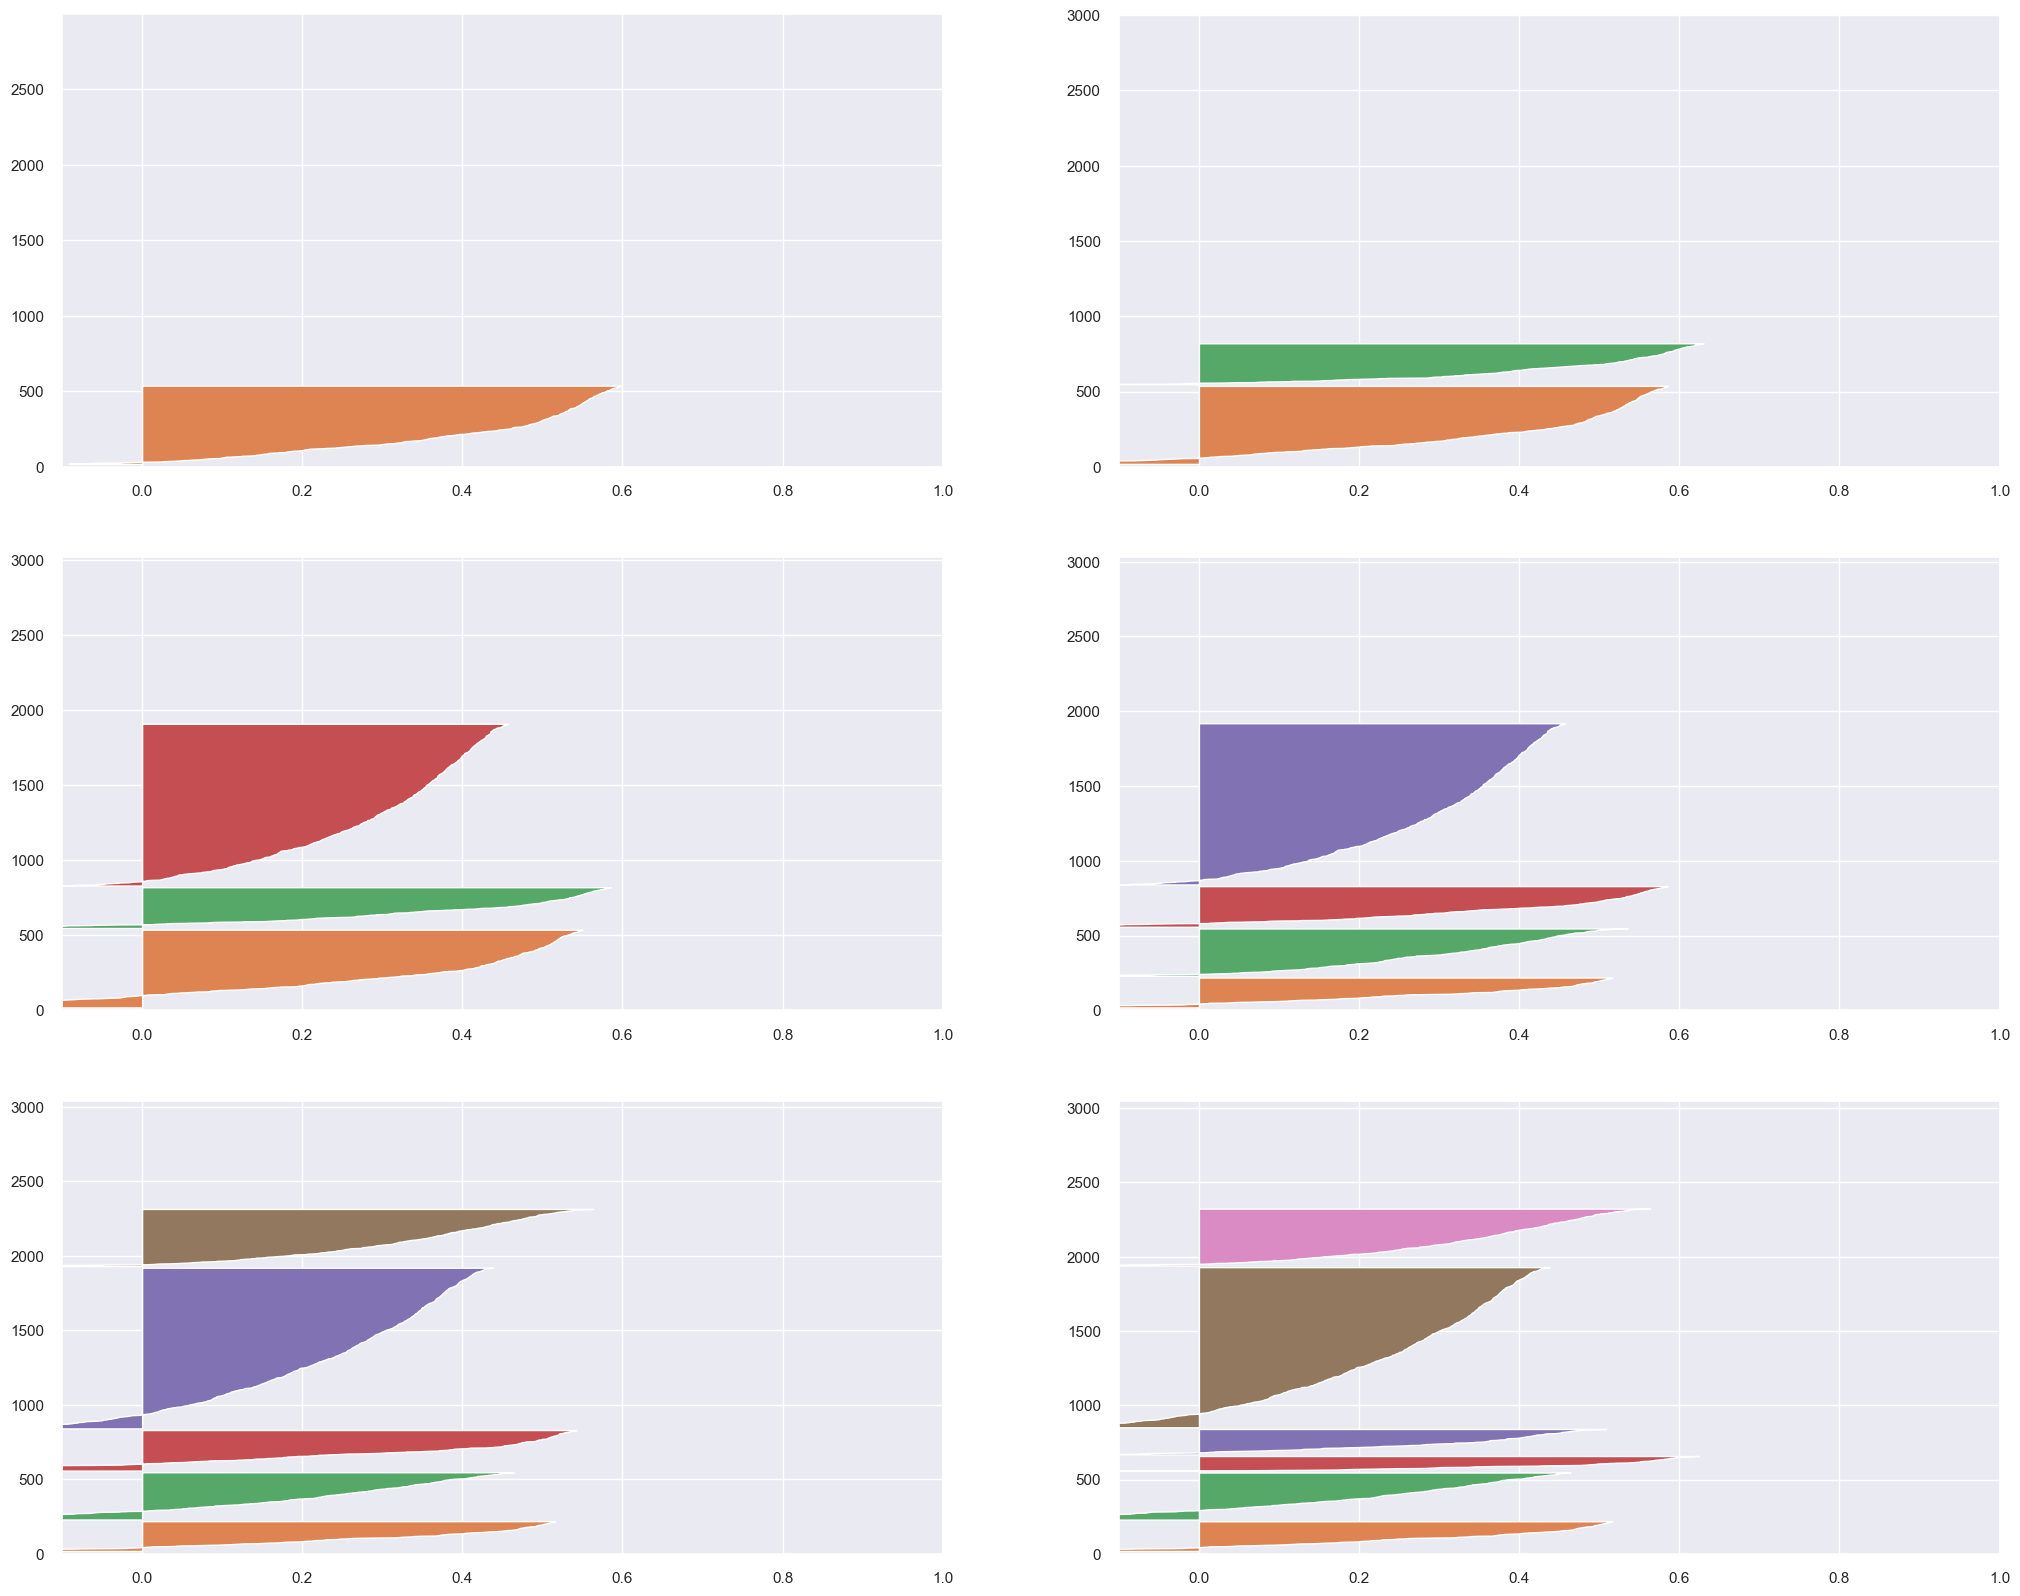

In [110]:
fig,ax = plt.subplots(3,2)
fig.set_size_inches(25,20)

for k in clusters:
    q,mod = divmod(k,2)
    
    ax[q-1,mod].set_xlim([-0.1,1])
    ax[q-1,mod].set_ylim([0,len(X) + (k+1)*10])
    # model definition    
    hc_model = hr.linkage(X,'ward')

    #model predict    
    labels = hr.fcluster(hc_model,k,criterion='maxclust')

    #model performace    
    hc_k = (m.silhouette_score(X,labels,metric='euclidean'))
    print(f'For K = {k} Silhouette: {hc_k}')
    
    ss_values = m.silhouette_samples(X,labels)
    y_lower=10
    for i in range(k):

        ith_ss_values = ss_values[labels==i]
        size_cluster = ith_ss_values.shape[0]
        ith_ss_values = np.sort(ith_ss_values)
        y_upper = y_lower + size_cluster
        ax[q-1,mod].fill_betweenx(np.arange(y_lower,y_upper),0,ith_ss_values)
        y_lower = y_upper+10

For K = 2 Silhouette: 0.023231991364748072
For K = 3 Silhouette: 0.05125525616781426
For K = 4 Silhouette: 0.052512031874811106
For K = 5 Silhouette: -0.00312212218304736
For K = 6 Silhouette: -0.05946915682671471
For K = 7 Silhouette: -0.08422842282592871


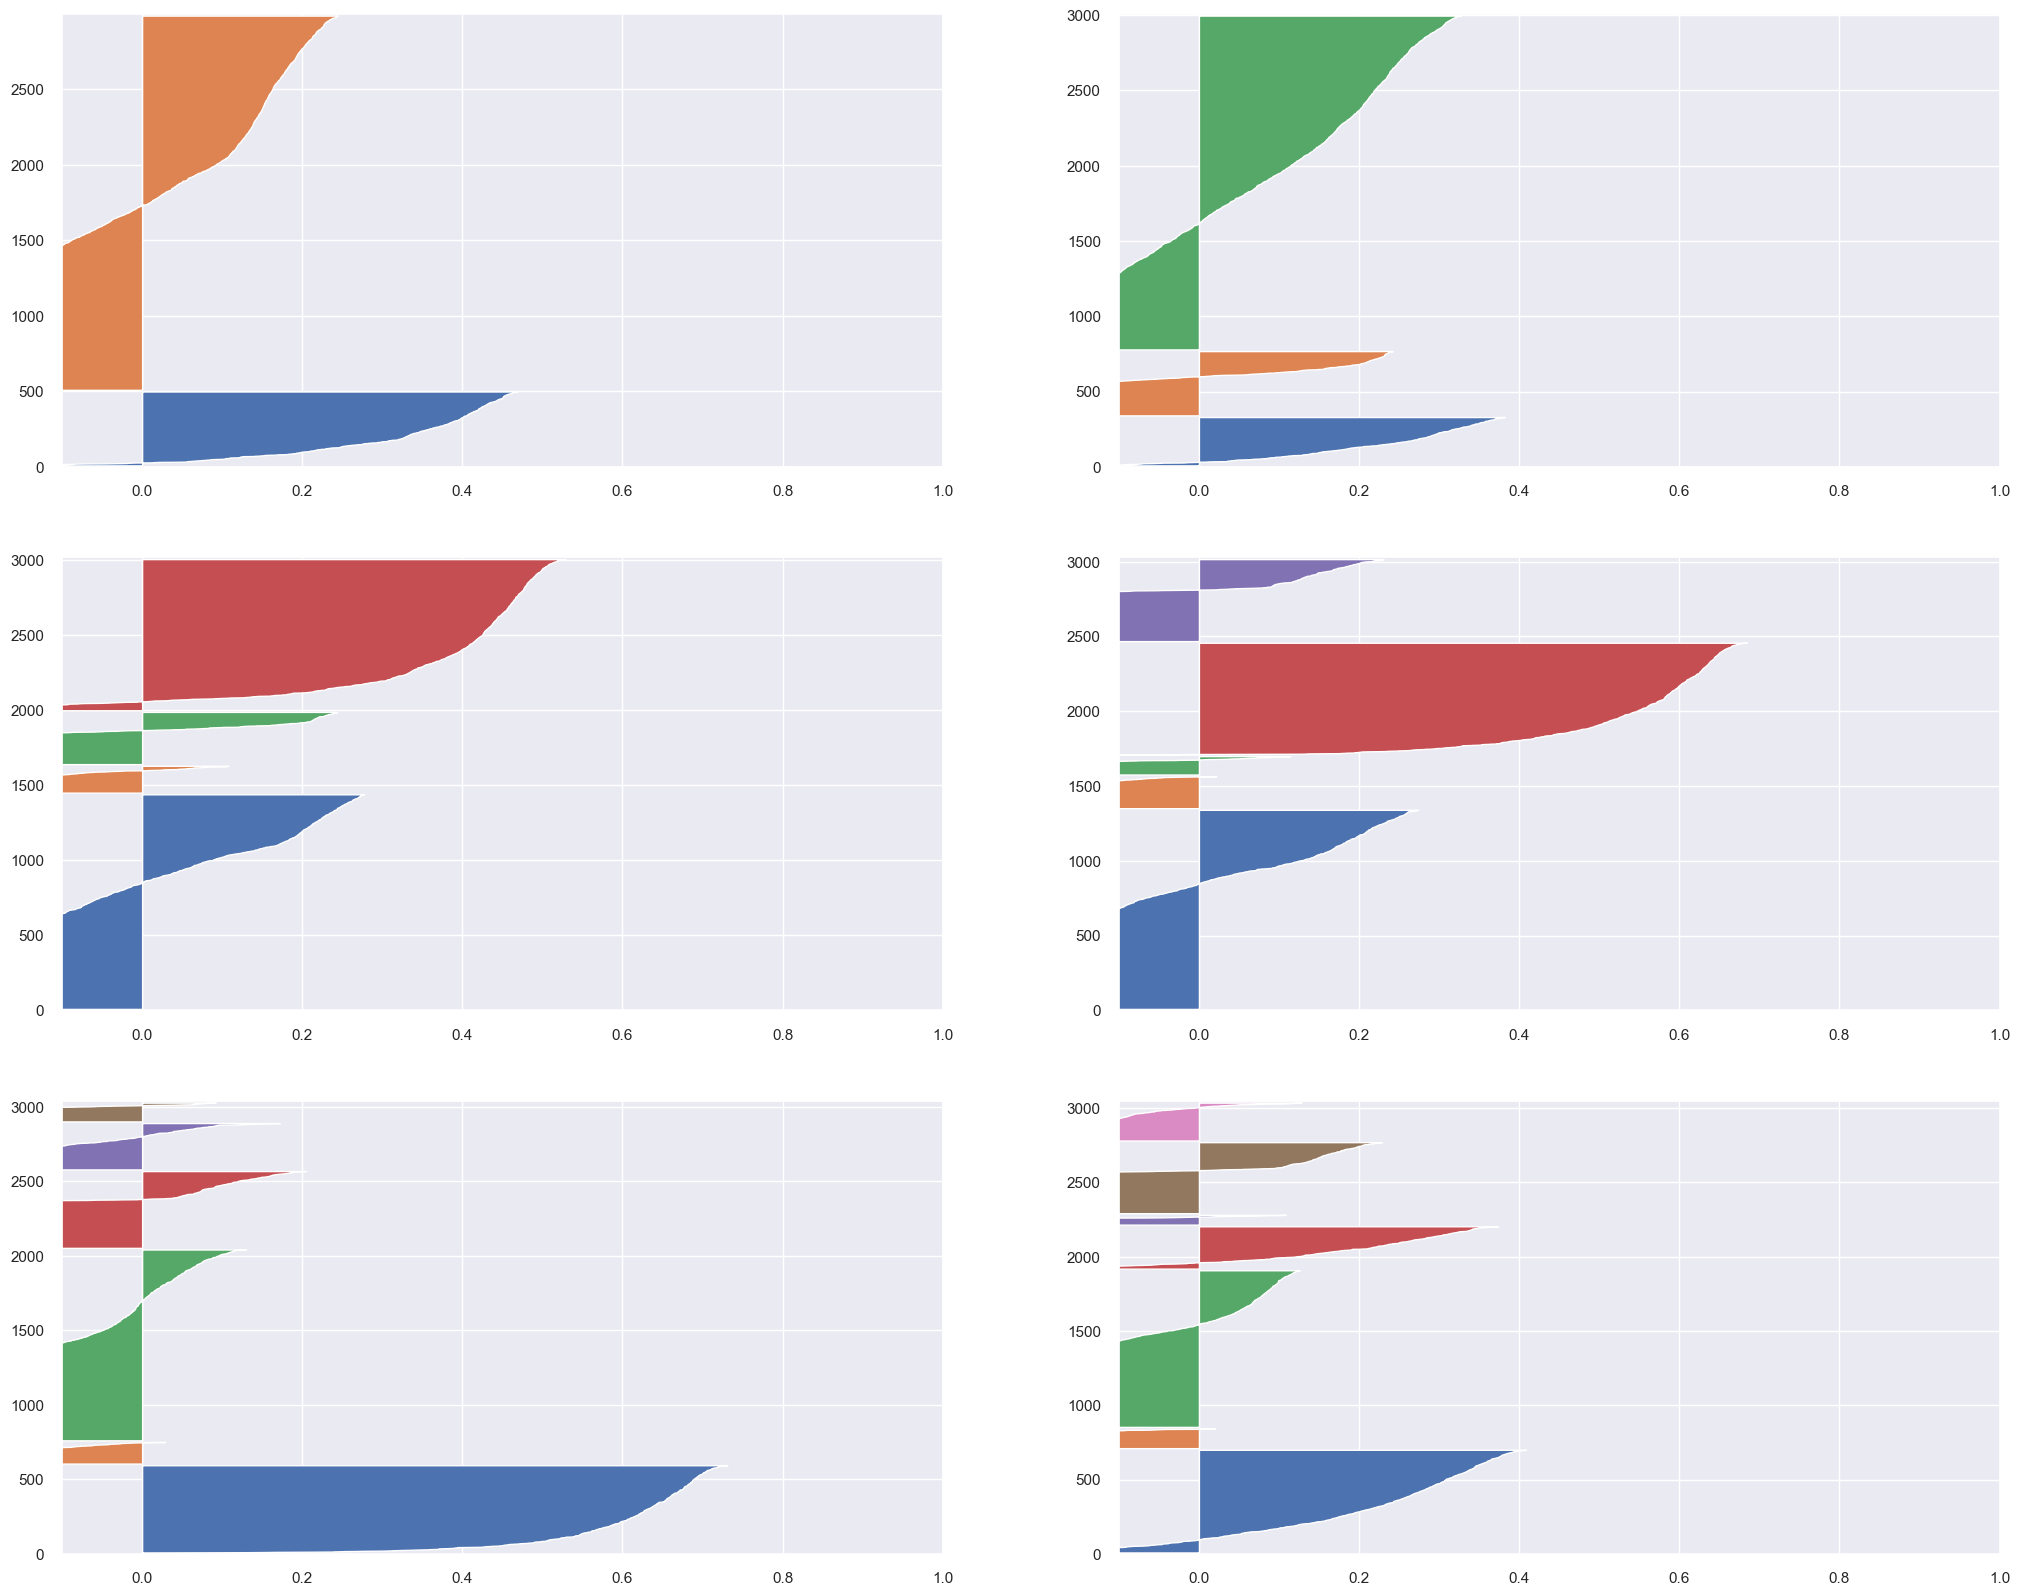

In [111]:
fig,ax = plt.subplots(3,2)
fig.set_size_inches(25,20)

for k in clusters:
    q,mod = divmod(k,2)
    
    ax[q-1,mod].set_xlim([-0.1,1])
    ax[q-1,mod].set_ylim([0,len(X) + (k+1)*10])
    # model definition
    gmm_model = mx.GaussianMixture(n_components=k)

    #model training
    gmm_model.fit(X)

    #model predict
    labels = gmm_model.predict(X)

    #model performace
    gmm_k = m.silhouette_score(X,labels,metric='euclidean')
    print(f'For K = {k} Silhouette: {gmm_k}')
    
    ss_values = m.silhouette_samples(X,labels)
    y_lower=10
    for i in range(k):

        ith_ss_values = ss_values[labels==i]
        size_cluster = ith_ss_values.shape[0]
        ith_ss_values = np.sort(ith_ss_values)
        y_upper = y_lower + size_cluster
        ax[q-1,mod].fill_betweenx(np.arange(y_lower,y_upper),0,ith_ss_values)
        y_lower = y_upper+10

## Within-Cluster Sum of Square (WSS)

In [112]:
wss = []
for k in clusters:
    # model definition
    kmeans = c.KMeans(init='random', n_clusters=k, n_init=10,max_iter=300,random_state=42)
    #model training
    kmeans.fit(X)
    
    wss.append(kmeans.inertia_)

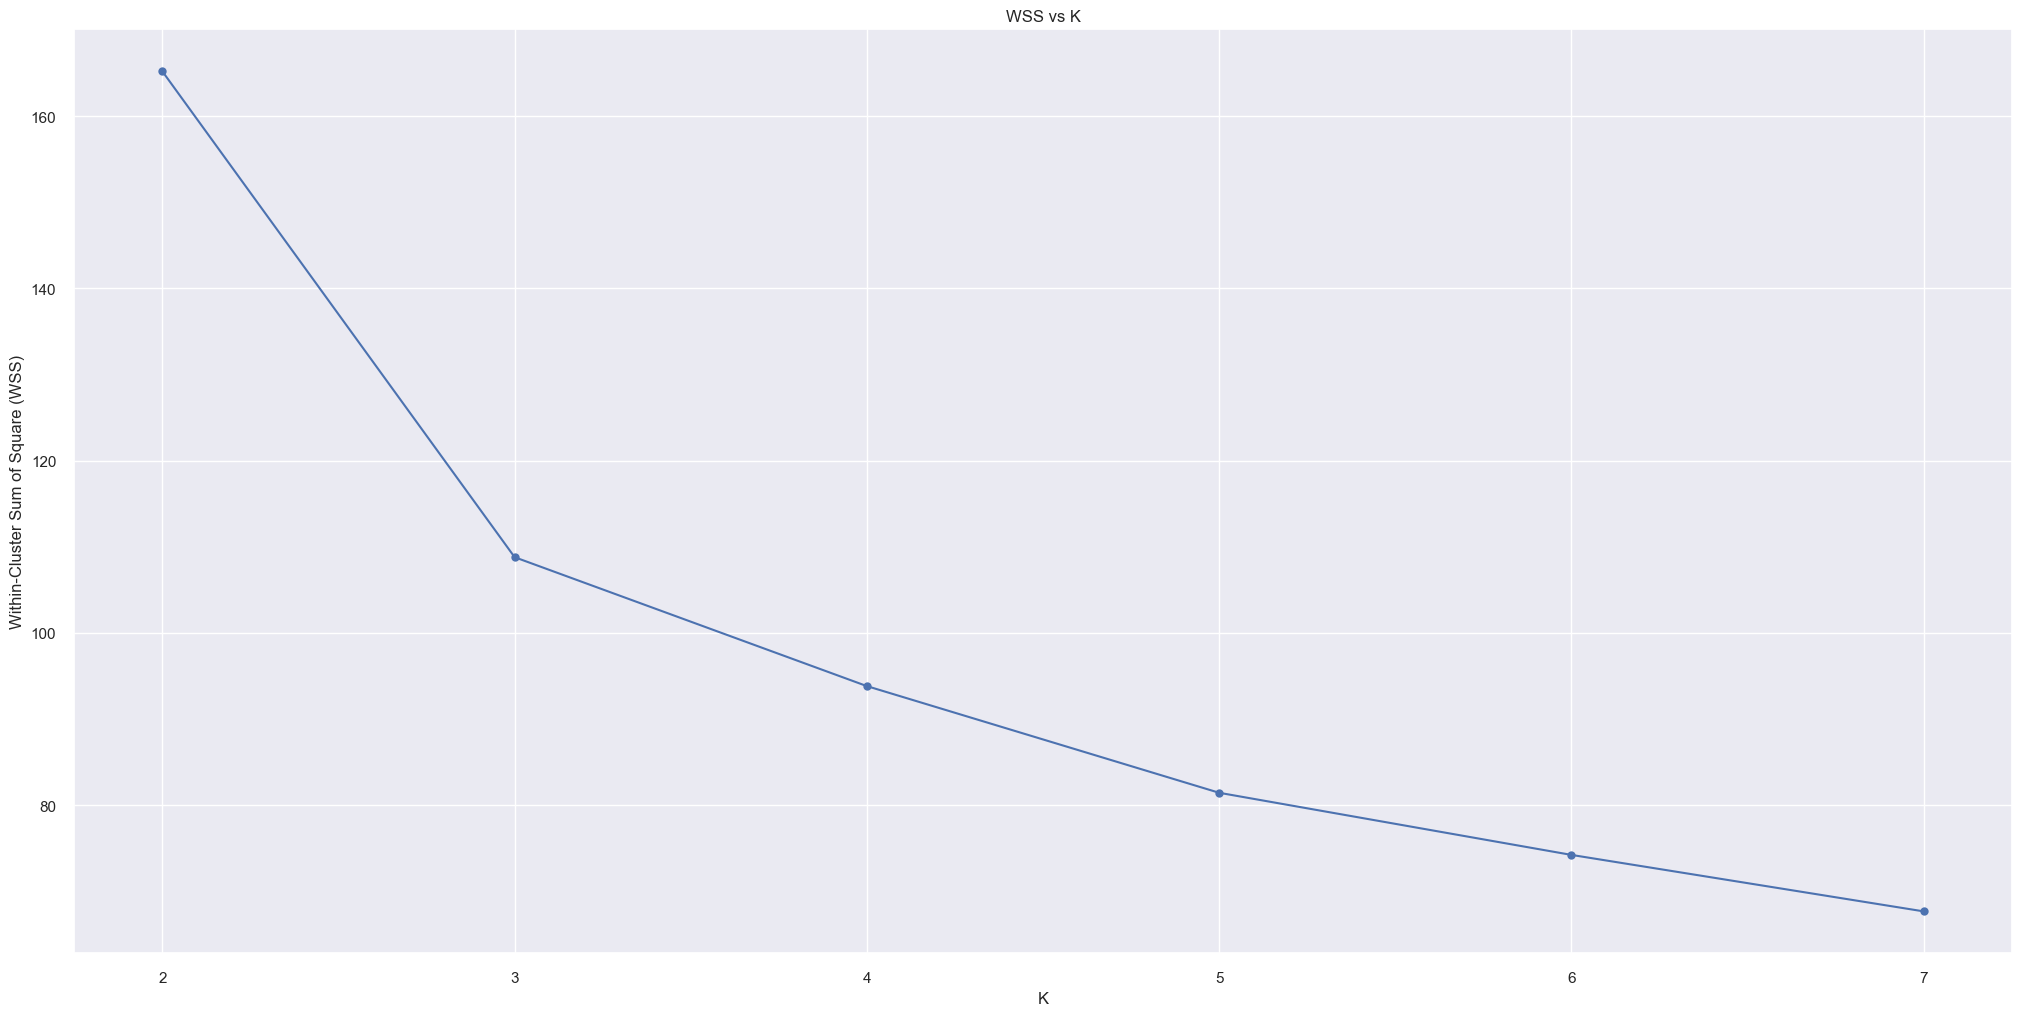

In [113]:
plt.plot(clusters,wss, marker = 'o');
plt.xlabel('K');
plt.ylabel('Within-Cluster Sum of Square (WSS)');
plt.title('WSS vs K');

Escolher os pontos com maior variação

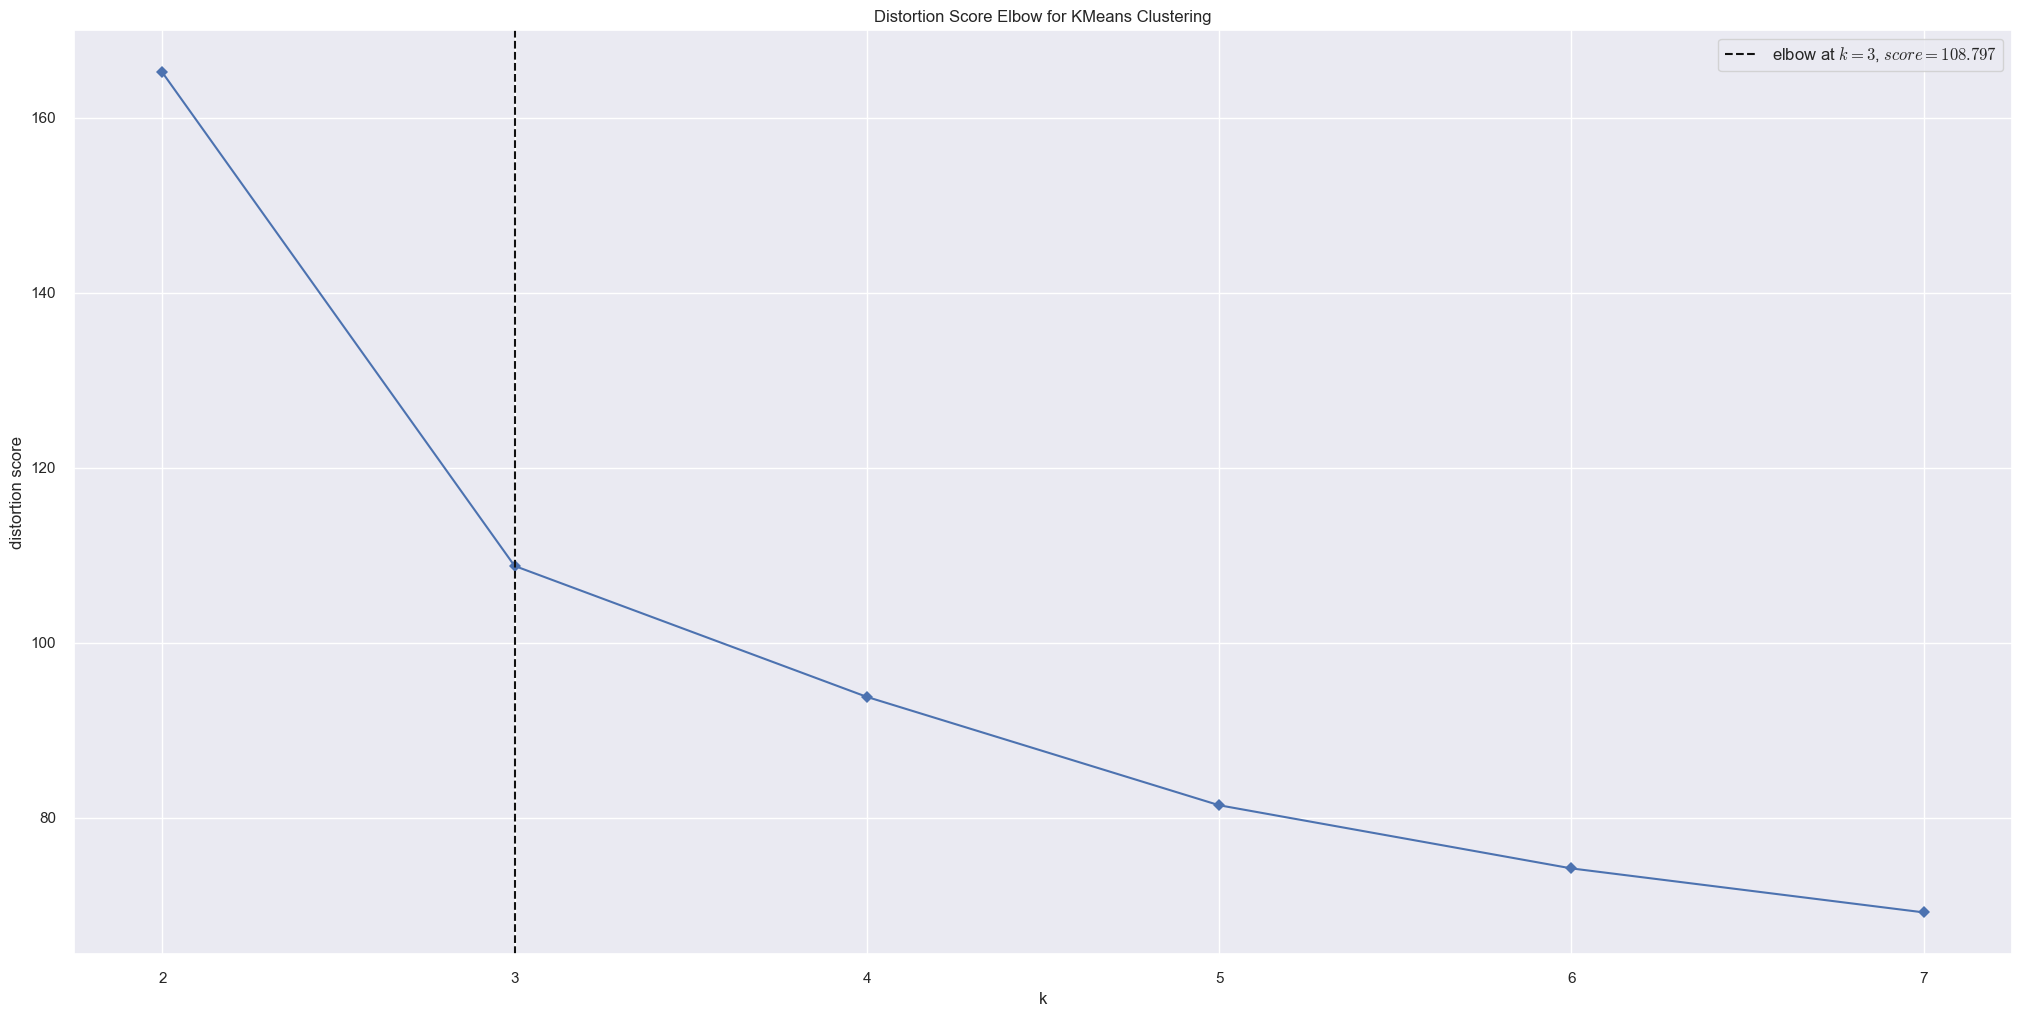

In [114]:
kmeans = KElbowVisualizer(c.KMeans(),k=clusters,timings=False)
kmeans.fit(X)
kmeans.show();

## Sillhouete Score

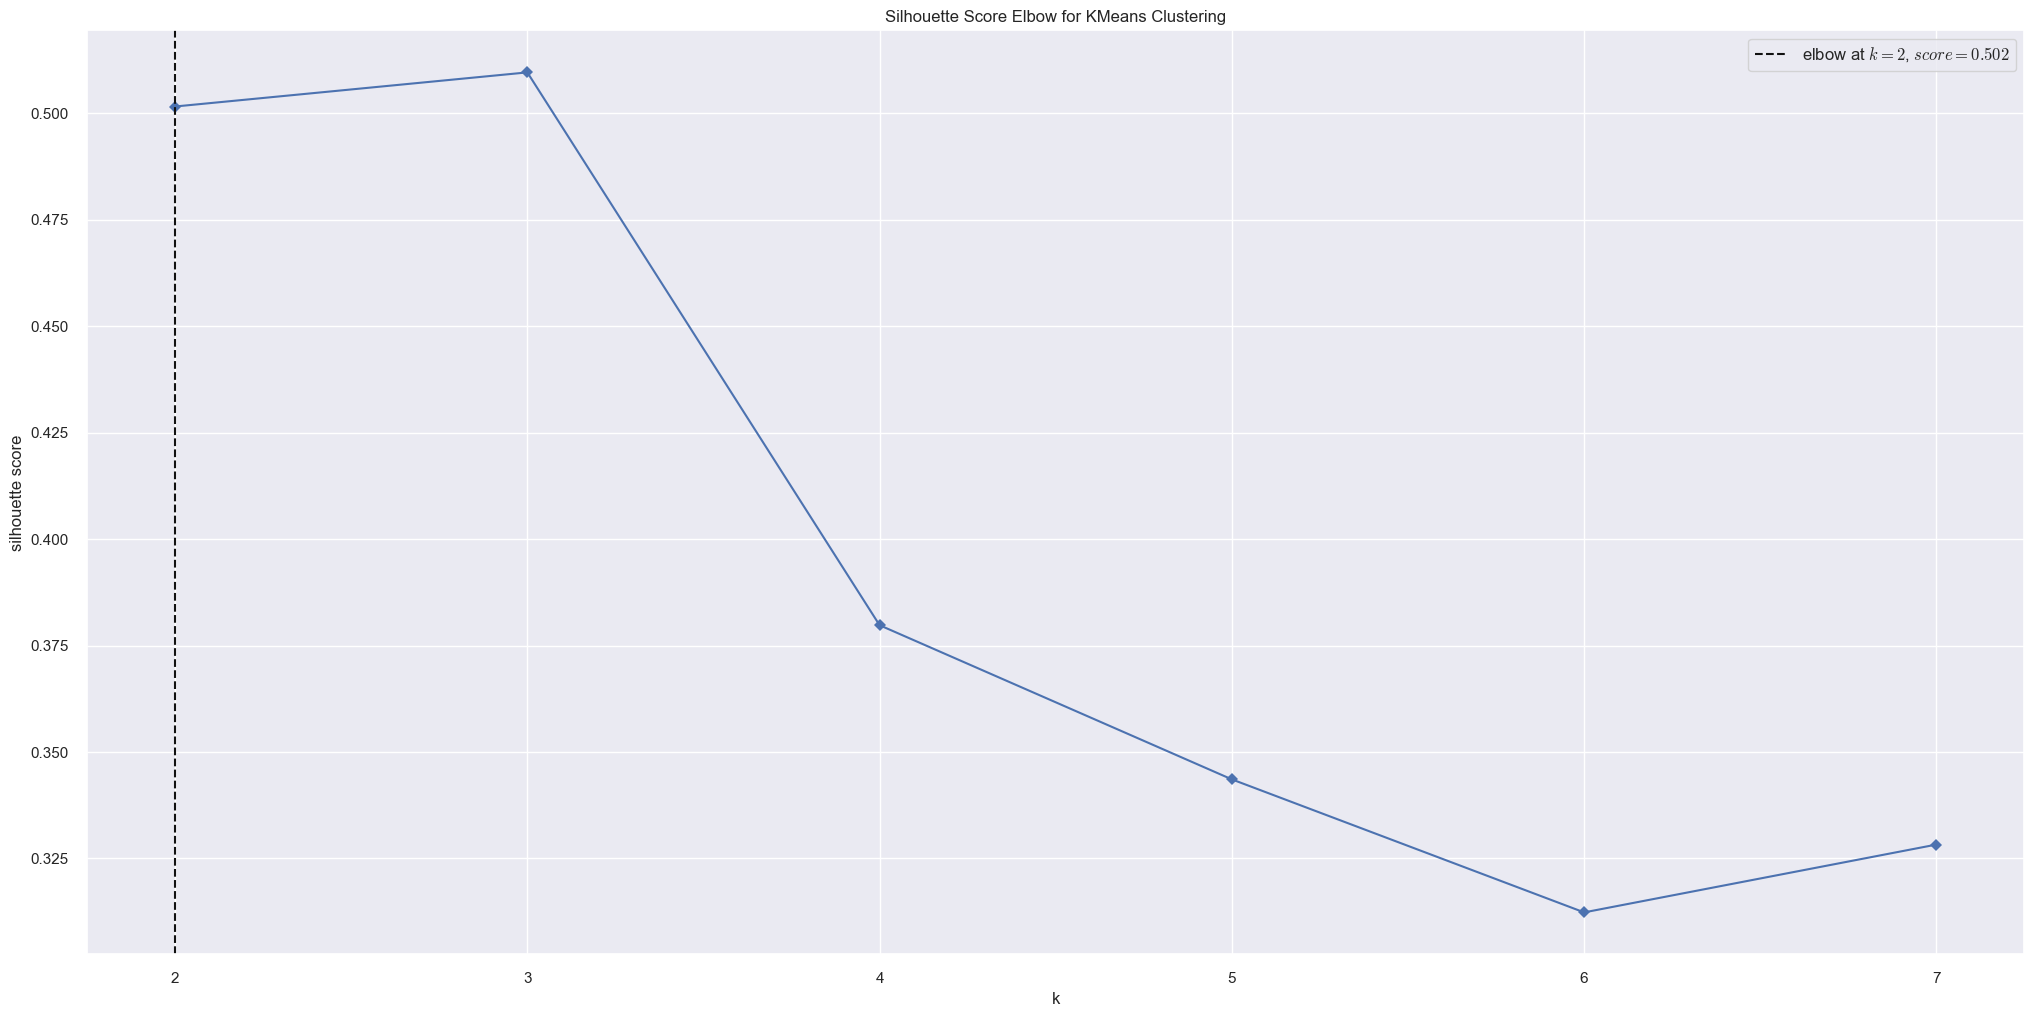

In [115]:
kmeans = KElbowVisualizer(c.KMeans(),k=clusters,metric='silhouette',timings=False)
kmeans.fit(X)
kmeans.show();

## Silhouete analisys

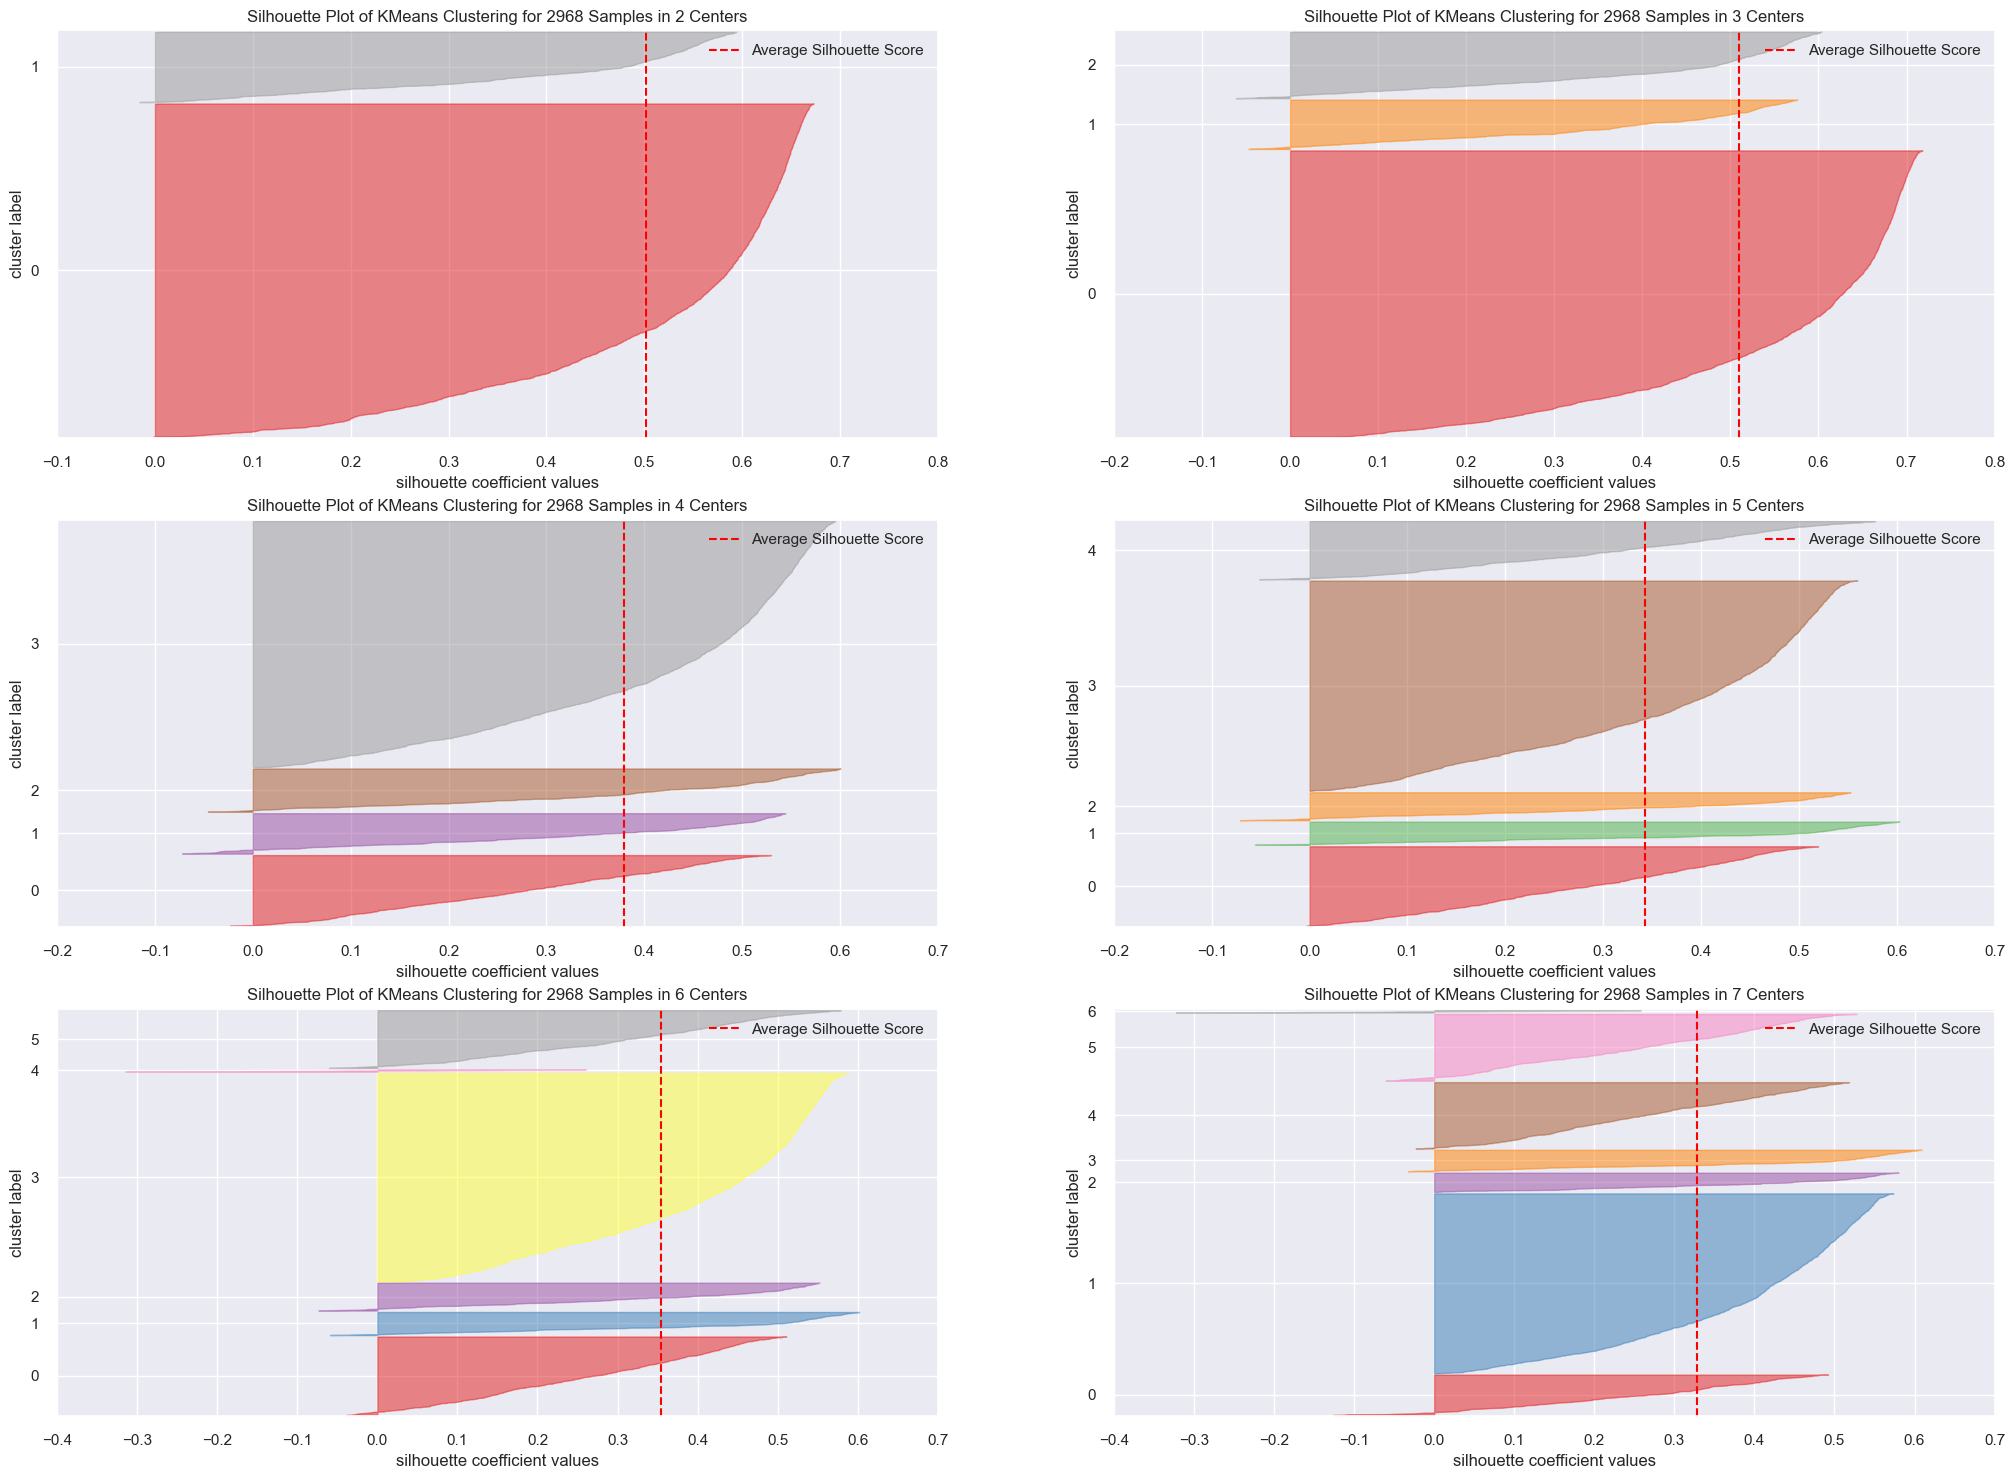

In [116]:
fig, ax = plt.subplots(3,2,figsize=(25,18))
#k=2
for k in clusters:
    from sklearn import cluster as c
    km = c.KMeans(n_clusters=k,init='random',n_init=10, max_iter=100,random_state=42)
    l,c = divmod(k,2)
    visualizer = SilhouetteVisualizer(km, color='yellowbrick',ax=ax[l-1][c])
    visualizer.fit(X)
    visualizer.finalize()

# Model training

## K-means

In [117]:
from sklearn import cluster as c

In [118]:
#model training
k = 4
kmeans = c.KMeans(init='random',n_clusters=k,n_init=10,max_iter=300,random_state=42)
#model training
kmeans.fit(X)
#clustering
labels = kmeans.labels_

### Cluster validation

In [119]:
# WSS
print('WSS value',kmeans.inertia_)

## SS (Silhouette Score)
print('SS value',m.silhouette_score(X,labels,metric='euclidean'))

WSS value 93.82981819493477
SS value 0.3797727887921887


### Cluster analysis

In [120]:
df9 = df7.copy()
df9['clusters'] = labels

C:\Users\Lavin\anaconda3\envs\insiders_clustering\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


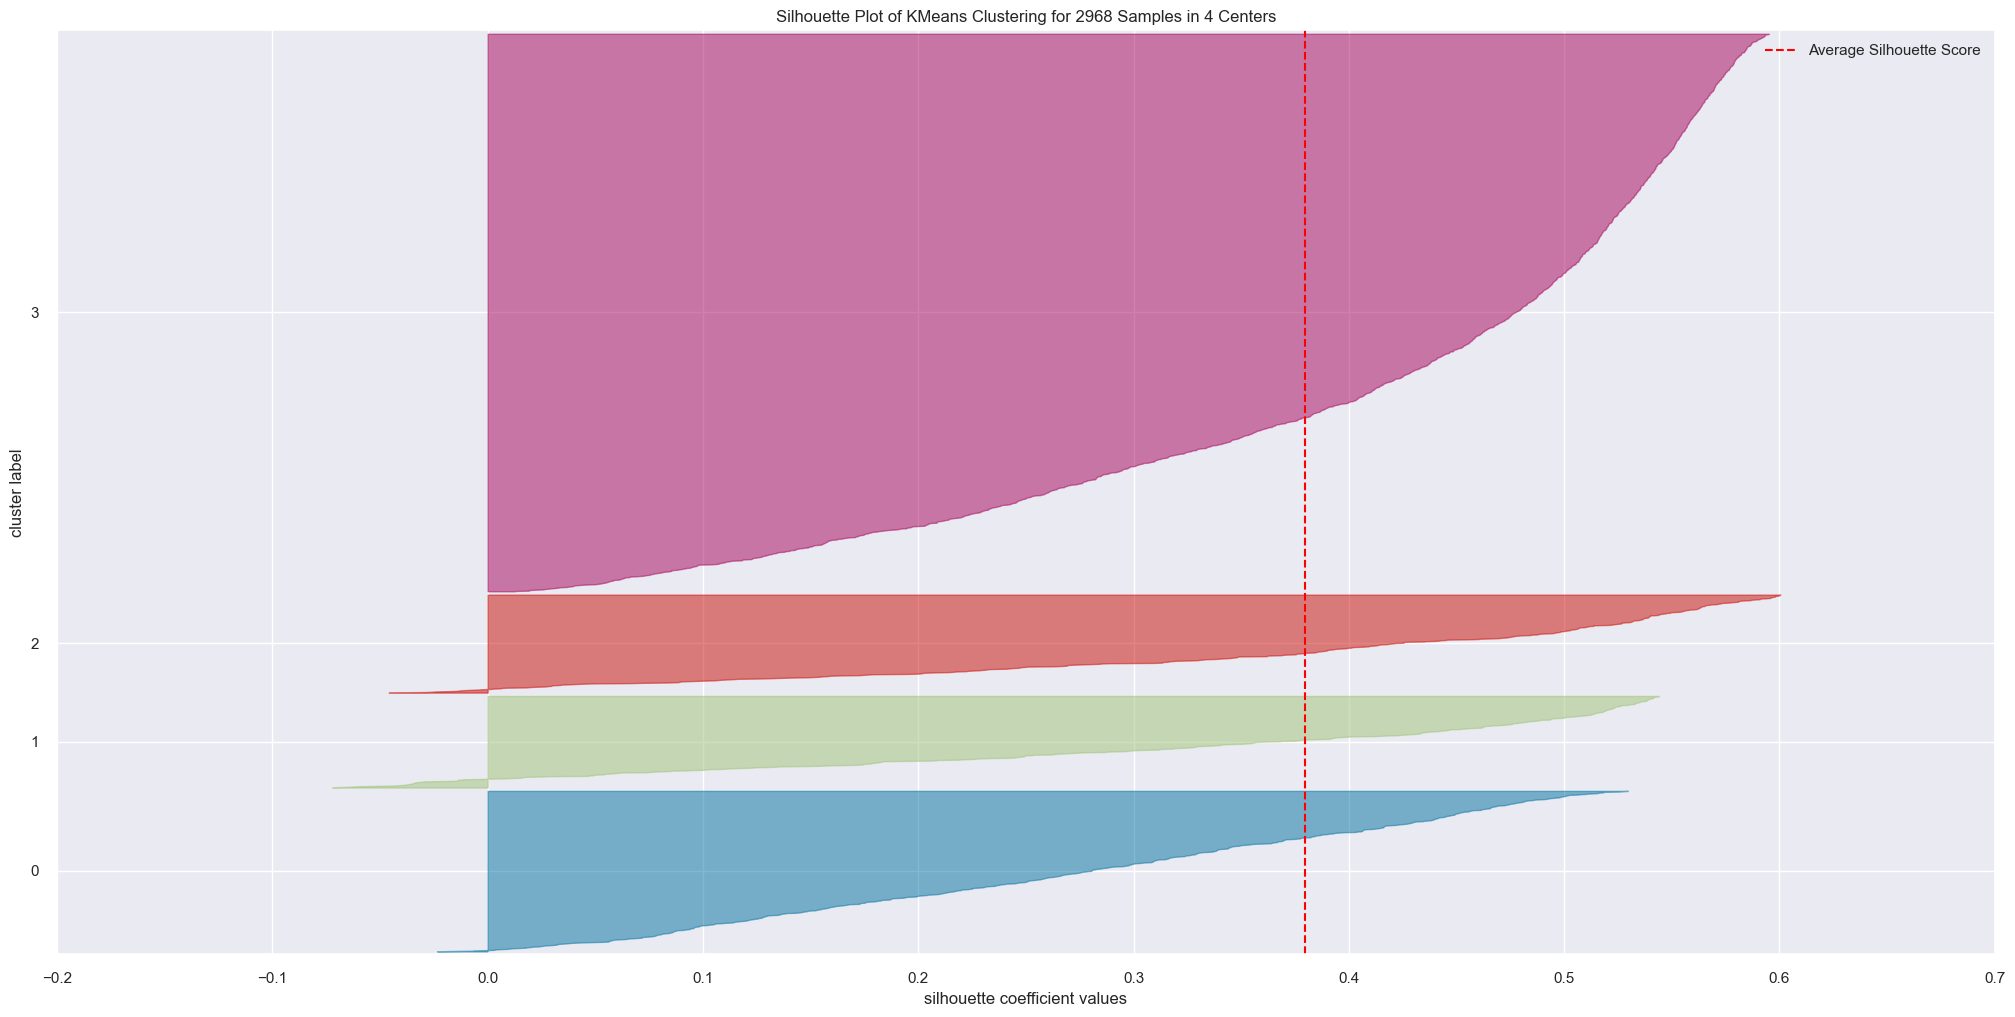

In [121]:
visualizer = SilhouetteVisualizer(kmeans,colors='yellowbrick')
visualizer.fit(X)
visualizer.finalize()

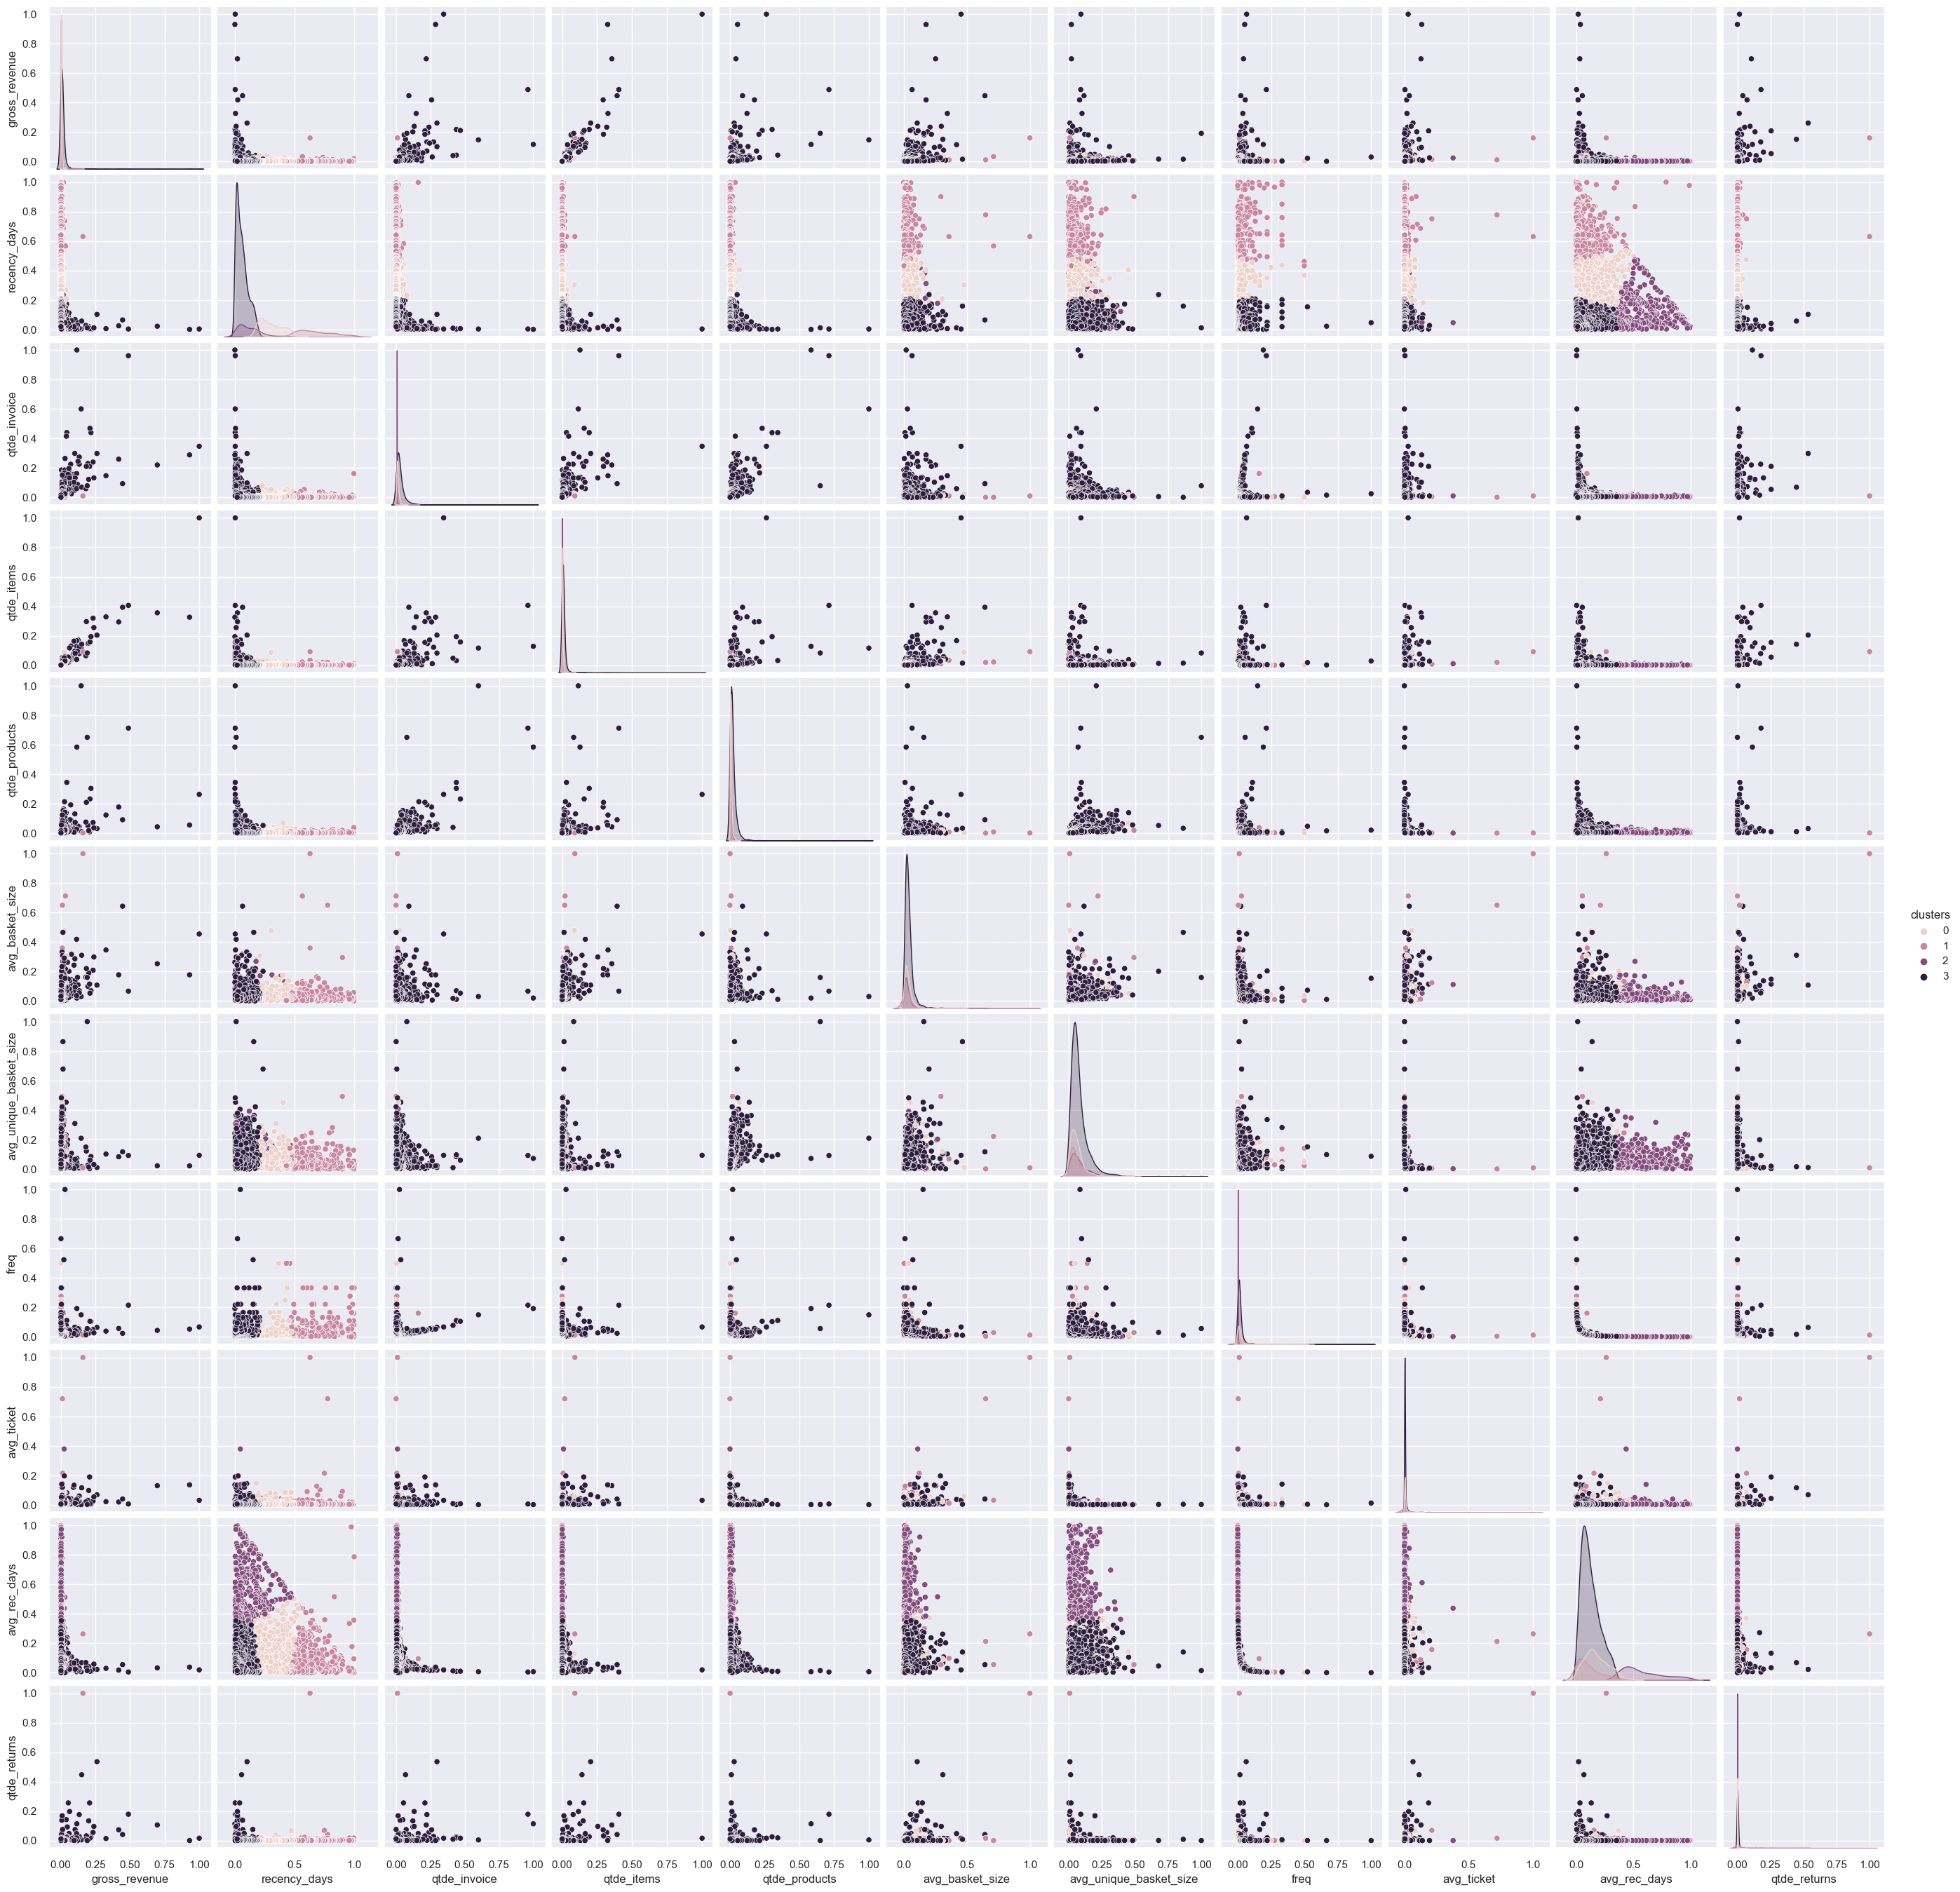

In [122]:
df_viz = df9.drop(columns='customer_id',axis=1)
sns.pairplot(df_viz,hue='clusters')

### UMAP - t-SNE
### Machine leraning - Manifold
PCA - Matrix, Espaço de distâncias - 9 condições - Colorários
UMAP, T-SNE (2009) - Manifold - Topologia

**UMAP**

In [123]:
import umap.umap_ as umap

In [124]:
reducer = umap.UMAP(n_neighbors=100,random_state=42)
embedding = reducer.fit_transform(X)

<AxesSubplot:xlabel='embedding_x', ylabel='embedding_y'>

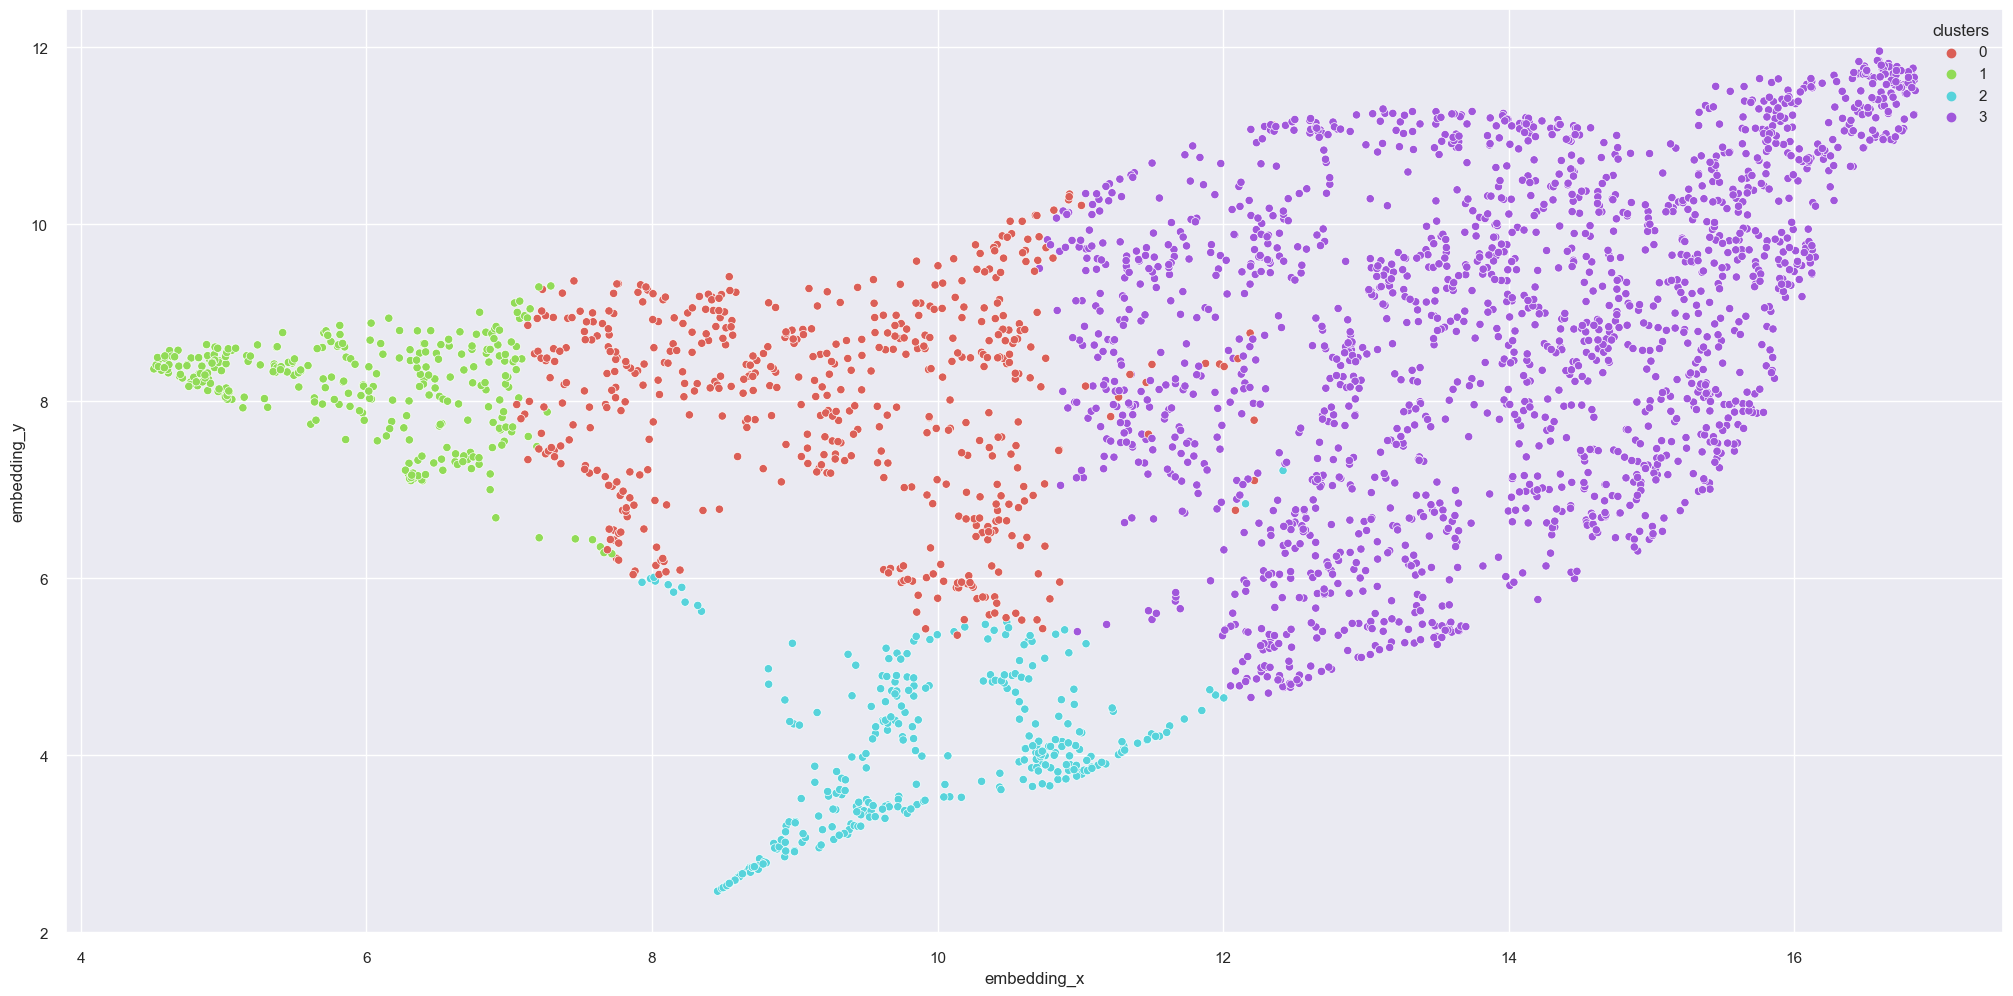

In [125]:
df_viz['embedding_x'] = embedding[:,0]
df_viz['embedding_y'] = embedding[:,1]

sns.scatterplot(x='embedding_x',y='embedding_y',hue='clusters', palette=sns.color_palette('hls',n_colors=len(df_viz['clusters'].unique())),data = df_viz)

In [126]:
#fig = px.scatter_3d(df9,x='recency_days',y='invoice_no',z='gross_revenue',color='clusters')
#fig.show()

### Cluster profile

In [127]:
df9.head()

customer_id  gross_revenue  recency_days  qtde_invoice  qtde_items  \
0      17850.0       0.019292      0.997319      0.160976    0.008799   
1      13047.0       0.011559      0.150134      0.039024    0.007056   
2      12583.0       0.024000      0.005362      0.068293    0.025538   
3      13748.0       0.003375      0.254692      0.019512    0.002225   
4      15100.0       0.003116      0.892761      0.009756    0.000401   

   qtde_products  avg_basket_size  avg_unique_basket_size      freq  \
0       0.037774         0.008317                0.025896  0.160512   
1       0.021695         0.025539                0.060260  0.014470   
2       0.029479         0.055623                0.048431  0.013441   
3       0.003446         0.014447                0.015400  0.004165   
4       0.000255         0.004272                0.000000  0.043717   

   avg_ticket  avg_rec_days  qtde_returns  clusters  
0    0.003595      0.094521      0.002330         1  
1    0.003764      0.071918      0.000666         3  
2    0.006010      0.060788      0.005547         3  
3    0.007125      0.251142      0.000000         0  
4    0.065116      0.020822      0.002441         1

In [128]:
# # number of customers
# df_cluster = df9[['customer_id','clusters']].groupby('clusters').count().reset_index()
# df_cluster['perc_customer'] = (df_cluster['customer_id']/df_cluster['customer_id'].sum())*100
# # Avg gross revenue
# df_avg_gross_revenue = df9[['gross_revenue','clusters']].groupby('clusters').mean().reset_index()
# df_cluster = pd.merge(df_cluster,df_avg_gross_revenue,how='inner',on='clusters')

# # avg recency days
# df_avg_recency_days =  df9[['recency_days','clusters']].groupby('clusters').mean().reset_index()
# df_cluster = pd.merge(df_cluster,df_avg_recency_days,how='inner',on='clusters')

# # avg invoice no
# df_avg_invoice_no =  df9[['invoice_no','clusters']].groupby('clusters').mean().reset_index()
# df_cluster = pd.merge(df_cluster,df_avg_invoice_no,how='inner',on='clusters')

# df_ticket =  df9[['avg_ticket','clusters']].groupby('clusters').mean().reset_index()
# df_cluster = pd.merge(df_cluster,df_ticket,how='inner',on='clusters')

In [129]:
df_cluster

NameError: name 'df_cluster' is not defined

## visualisation